# Week HW 18

Last Audit: HW18

# Pips


In [1]:
%pip install gurobipy>=10
%pip install gurobipy_pandas
%pip install pandas
%pip install matplotlib
%pip install scipy
%pip install scikit-learn

zsh:1: 10 not found
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Import


In [2]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [3]:
data_size = 50
train_size = 0.8
testing_size = 0.2

# data_size = 10 # 最小要是 2
# train_size = 1
# testing_size = 0

T = 10
service_level = 0.95  # 服務水準
M = 5000000

assigned_Fs = np.arange(0.1, 1.0, 0.1)
assigned_Ts = list(range(2, T))  # 2 到 T-1

np.random.seed(0)


# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 2000
MIPGAP = 0.3
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [4]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [5]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [6]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

## Visualization 

In [7]:
def plot_strategies_profits_scatter(save_type, dfs):
    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if dfs[i] is None or dfs[j] is None:
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [8]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            ratio = max_profit / baseline_profit
            ratios[f"S{idx}"] = ratio - 1  # 相對偏差

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [9]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
            test_ratios[f"S{idx}"] = test_ratio
        if train_profit is not None and train_profit != -1:
            train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

## Others

In [10]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [11]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [12]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [13]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "Q0_vars": Q0_vars,
        "Q1_vars": Q1_vars,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Import Data


## Data1: Training data for LR


### Making full data


In [14]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(80, 90, data_size),
        "X2": np.random.randint(1, 4, data_size),
    }
)

full_df

X1  X2
0   85.488135   2
1   87.151894   3
2   86.027634   1
3   85.448832   1
4   84.236548   3
5   86.458941   1
6   84.375872   1
7   88.917730   1
8   89.636628   1
9   83.834415   1
10  87.917250   1
11  85.288949   3
12  85.680446   1
13  89.255966   3
14  80.710361   2
15  80.871293   2
16  80.202184   2
17  88.326198   1
18  87.781568   2
19  88.700121   2
20  89.786183   2
21  87.991586   1
22  84.614794   2
23  87.805292   3
24  81.182744   1
25  86.399210   2
26  81.433533   3
27  89.446689   1
28  85.218483   3
29  84.146619   1
30  82.645556   2
31  87.742337   3
32  84.561503   3
33  85.684339   2
34  80.187898   1
35  86.176355   2
36  86.120957   2
37  86.169340   1
38  89.437481   3
39  86.818203   3
40  83.595079   3
41  84.370320   3
42  86.976312   2
43  80.602255   3
44  86.667667   3
45  86.706379   3
46  82.103826   3
47  81.289263   3
48  83.154284   1
49  83.637108   2

In [15]:
features_num = full_df.shape[1]
features_num

2

### Split training and testing data


In [16]:
training_df, testing_df = (
    full_df[: int(data_size * train_size)],
    full_df[int(data_size * train_size) :],
)
testing_df.reset_index(drop=True, inplace=True)
print(f"training_data size: {training_df.shape}")
print(f"testing_df size: {testing_df.shape}")

training_data size: (40, 2)
testing_df size: (10, 2)


In [17]:
# #### Only for testing
# training_df = testing_df = full_df

## Data2: demand_df


### mu of each time(t)


In [18]:
# 設定 b0, b1, b2
b0 = 0
b1 = 0.17
b2 = 0.01


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    # 設定隨機種子
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b1 * training_df["X1"] + b2 * training_df["X2"] + b0 + random_noises[t - 1]
        )

    return mu_matrix

In [19]:
# mu_matrix = cal_mu_matrix(data_size, T, full_df)
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[0]}")

mu_matrix shape: (50, 10)
mu_matrix[0]: 
[16.3170353  14.95314017 15.53172094 16.79387616 16.42054095 13.57570508
 15.50307137 14.40162575 14.4497641  14.96358146]


### sigma matrix


In [20]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)
X = np.random.rand(feature_num, data_size)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)
print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

coefficients.shape: (2, 10)
coefficients: [[-0.45998405  0.47038804  0.92437709 -0.50249371  0.15231467  0.18408386
   0.14450381 -0.55383673  0.90549802 -0.10574924]
 [ 0.69281734  0.39895855 -0.4051261   0.62759564 -0.20698852  0.76220639
   0.16254575  0.76347072  0.38506318  0.45050856]]


In [21]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (data_size, T)
linear_combination = c + X.T @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)

# 再將值縮放到 [2, 10] 的範圍
sigma_matrix = 2 + sigma_matrix * 8  # shape: (data_size, T)

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

((50, 10),
 array([[7.5545925 , 8.09568202, 7.77555286, 7.45064612, 7.2441454 ,
         8.16727318, 7.60421028, 7.53549838, 8.4102581 , 7.64903433],
        [7.26096999, 8.13280781, 8.09245244, 7.15371426, 7.33834024,
         8.06697829, 7.60865829, 7.1955186 , 8.53379246, 7.51941856],
        [7.97999166, 8.3604397 , 7.57858175, 7.84095898, 7.10095093,
         8.59018207, 7.72941204, 7.99994936, 8.66084101, 7.94052381],
        [6.97568302, 7.80865689, 8.06166191, 6.91939404, 7.41542125,
         7.61442659, 7.47360002, 6.8926208 , 8.1631005 , 7.28515595],
        [7.21566136, 7.78566609, 7.82449567, 7.15796688, 7.34392385,
         7.712197  , 7.47333574, 7.17010289, 8.0641764 , 7.39337687],
        [6.96551176, 7.92003796, 8.16170578, 6.89366124, 7.42087399,
         7.71979296, 7.51529444, 6.87226866, 8.31981594, 7.31380961],
        [7.73500841, 8.06762212, 7.55001869, 7.63433448, 7.1822152 ,
         8.22693234, 7.59985161, 7.74324064, 8.32081402, 7.72973532],
        [6.87197

### corr matrix


In [22]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [23]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (50, 10, 10)
cov_matrices: 
[[ 57.07186789  21.66533985  32.64735859  33.0633452  -21.22152281
   -9.96364751  -5.69140653 -15.70881574 -31.06223149  -1.20914056]
 [ 21.66533985  65.54006733  40.64398007  20.76442165 -31.31491122
   -7.84935264 -22.56841656   4.4064001    7.48669692  -3.04210621]
 [ 32.64735859  40.64398007  60.4592222   15.04679434 -24.13575082
  -15.02024548 -32.61106153   0.61888773 -27.08937775  -7.65501169]
 [ 33.0633452   20.76442165  15.04679434  55.51212758 -23.40917425
   -4.80492719   9.41812495 -35.42828362   5.58562465  13.91570037]
 [-21.22152281 -31.31491122 -24.13575082 -23.40917425  52.4776426
   21.97379258  16.54289691  16.050019    -9.36536795  -6.01475406]
 [ -9.96364751  -7.84935264 -15.02024548  -4.80492719  21.97379258
   66.70435124  40.88364187  32.03436791 -23.47358153   9.209504  ]
 [ -5.69140653 -22.56841656 -32.61106153   9.41812495  16.54289691
   40.88364187  57.82401402   2.23139988  -0.62494879  28.26058158]
 [-15.70

In [24]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: True


### MVN stimulation for demand_df


In [25]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   21.628301  -8.392809   4.140547  14.794692  32.952061  17.580815   
1   26.776223  14.349939  17.000444  15.770674  18.548975  21.409526   
2   39.015924  28.836781  38.348790  27.637901   8.086327   2.845409   
3   11.598733  24.950174  15.869886   5.372479  16.790273  14.914910   
4   13.098249  12.011826  16.324598  19.408115  13.968583  -4.438156   
5   16.870007  24.713646  24.204669  14.020862  10.292790  11.518817   
6    8.339548  24.578702  25.419531  15.268904  10.785589   7.878314   
7   12.897472  16.162037  16.396734  19.253830  20.497885  24.811252   
8   27.035954  24.962339  27.672613  13.750945   2.556598  14.952471   
9   22.463167  13.582489  20.818504  13.499535  15.046224  12.401391   
10   2.175715  -0.367832  -7.644239   8.980925  18.415047  15.679114   
11  12.047023  -3.599767  -0.488695   7.239187  28.899654  17.241392   
12  13.141306   9.370526   8.791118  19.427896  19.288655  10.834549   
13  21.864248  17.005986  22.685272  12.859976  12.789747   9.544221   
14  26.948029  10.586702  25.702509  18.878185   5.164556   3.824112   
15  15.395007  23.033233  19.508439   3.875423  19.615005  10.572267   
16  28.335755  18.790605  23.357549   6.534795  12.123297  12.210429   
17  11.643432  14.379079  10.522533  18.512794  17.435063  27.795343   
18   5.723222  26.476989  21.168103  16.001752  16.526143   6.230008   
19  22.227637  30.389835  24.627904  18.349065  11.394568  14.490510   
20  24.824048  14.182223  19.258640  28.408800  20.884268  12.373145   
21  13.406453  15.397041  12.139559  18.708534  22.317679  24.395873   
22  17.293853  21.590021  16.700851  22.374612  12.403296   7.829604   
23  24.534162  22.954822  15.992604  24.613209   7.178288   5.572604   
24  16.422545  15.912030  21.859205  23.807423  17.692969   8.542883   
25  12.319538   8.397246  12.357421  17.128546  13.759495  15.672482   
26  17.207631  25.367601  16.176612  23.245387   8.271251   8.029378   
27  16.514388  15.906502   3.954046  30.706518  10.767977   7.123747   
28  16.095546   7.617504  19.173828  12.619443  17.967923   9.773403   
29  23.575593  24.416007  18.332358  26.928863   3.350522  20.930862   
30  21.465770  22.032454  32.319985  16.933798  12.132272  13.065885   
31  14.106839  19.142243  20.675733   9.448357  18.882570  16.584709   
32  14.470866  28.570515  18.737620  20.155615  10.833259  10.821148   
33   1.818108  20.756198  10.115090  22.345108  12.813436  26.434711   
34   5.726470  11.949030   8.605253   9.207319  18.791679  13.050483   
35  14.571100  23.835885  20.108695  31.505264   8.305727  14.725176   
36  16.978836   9.174192  11.170106  19.348628  18.738221  21.312541   
37  17.975950  13.606940   8.854614  22.234803  12.207279  16.229842   
38  14.997624  27.577241  33.357254  13.076502  18.519012   4.006902   
39  10.841472  23.116619  13.766480   8.865426  20.814289  16.847575   
40  20.581833  21.070175  11.051923  27.322494   9.989638  14.025159   
41  28.559357  19.207504  27.982127  13.835669   6.783919   5.127769   
42  10.723310   5.374414   7.301122   6.503633  26.058721  14.098281   
43  20.898750  10.311809  15.158634  25.935436  10.673023  12.381624   
44  18.709168  13.802997  13.869662  20.275010  12.843624   5.339410   
45  24.517350  15.412297  22.592229  21.952163   3.490277  16.658650   
46  11.281327  11.612970  12.802136  21.401725   1.559935   8.527109   
47  28.041519  23.885946  23.577216  18.437336  -1.137721  -1.948502   
48  15.719964  15.283770  16.045419   4.555961  32.569124  10.874541   
49  28.533993   7.486556  23.432315  25.053638  10.300570   5.396351   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   28.779684  12.948621   4.257279   21.063419  
1   20.580347  21.779295   3.149199   15.268276  
2    4.915871  12.413783   8.949089   26.533160  
3   12.752493  26.317817  18.598380   13.990928  
4    4.004635  -6.768735  21.035061    4.466441  
5    8.924556  20.506724  14.01

### Replace negative values to 0


In [26]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   21.628301   0.000000   4.140547  14.794692  32.952061  17.580815   
1   26.776223  14.349939  17.000444  15.770674  18.548975  21.409526   
2   39.015924  28.836781  38.348790  27.637901   8.086327   2.845409   
3   11.598733  24.950174  15.869886   5.372479  16.790273  14.914910   
4   13.098249  12.011826  16.324598  19.408115  13.968583   0.000000   
5   16.870007  24.713646  24.204669  14.020862  10.292790  11.518817   
6    8.339548  24.578702  25.419531  15.268904  10.785589   7.878314   
7   12.897472  16.162037  16.396734  19.253830  20.497885  24.811252   
8   27.035954  24.962339  27.672613  13.750945   2.556598  14.952471   
9   22.463167  13.582489  20.818504  13.499535  15.046224  12.401391   
10   2.175715   0.000000   0.000000   8.980925  18.415047  15.679114   
11  12.047023   0.000000   0.000000   7.239187  28.899654  17.241392   
12  13.141306   9.370526   8.791118  19.427896  19.288655  10.834549   
13  21.864248  17.005986  22.685272  12.859976  12.789747   9.544221   
14  26.948029  10.586702  25.702509  18.878185   5.164556   3.824112   
15  15.395007  23.033233  19.508439   3.875423  19.615005  10.572267   
16  28.335755  18.790605  23.357549   6.534795  12.123297  12.210429   
17  11.643432  14.379079  10.522533  18.512794  17.435063  27.795343   
18   5.723222  26.476989  21.168103  16.001752  16.526143   6.230008   
19  22.227637  30.389835  24.627904  18.349065  11.394568  14.490510   
20  24.824048  14.182223  19.258640  28.408800  20.884268  12.373145   
21  13.406453  15.397041  12.139559  18.708534  22.317679  24.395873   
22  17.293853  21.590021  16.700851  22.374612  12.403296   7.829604   
23  24.534162  22.954822  15.992604  24.613209   7.178288   5.572604   
24  16.422545  15.912030  21.859205  23.807423  17.692969   8.542883   
25  12.319538   8.397246  12.357421  17.128546  13.759495  15.672482   
26  17.207631  25.367601  16.176612  23.245387   8.271251   8.029378   
27  16.514388  15.906502   3.954046  30.706518  10.767977   7.123747   
28  16.095546   7.617504  19.173828  12.619443  17.967923   9.773403   
29  23.575593  24.416007  18.332358  26.928863   3.350522  20.930862   
30  21.465770  22.032454  32.319985  16.933798  12.132272  13.065885   
31  14.106839  19.142243  20.675733   9.448357  18.882570  16.584709   
32  14.470866  28.570515  18.737620  20.155615  10.833259  10.821148   
33   1.818108  20.756198  10.115090  22.345108  12.813436  26.434711   
34   5.726470  11.949030   8.605253   9.207319  18.791679  13.050483   
35  14.571100  23.835885  20.108695  31.505264   8.305727  14.725176   
36  16.978836   9.174192  11.170106  19.348628  18.738221  21.312541   
37  17.975950  13.606940   8.854614  22.234803  12.207279  16.229842   
38  14.997624  27.577241  33.357254  13.076502  18.519012   4.006902   
39  10.841472  23.116619  13.766480   8.865426  20.814289  16.847575   
40  20.581833  21.070175  11.051923  27.322494   9.989638  14.025159   
41  28.559357  19.207504  27.982127  13.835669   6.783919   5.127769   
42  10.723310   5.374414   7.301122   6.503633  26.058721  14.098281   
43  20.898750  10.311809  15.158634  25.935436  10.673023  12.381624   
44  18.709168  13.802997  13.869662  20.275010  12.843624   5.339410   
45  24.517350  15.412297  22.592229  21.952163   3.490277  16.658650   
46  11.281327  11.612970  12.802136  21.401725   1.559935   8.527109   
47  28.041519  23.885946  23.577216  18.437336   0.000000   0.000000   
48  15.719964  15.283770  16.045419   4.555961  32.569124  10.874541   
49  28.533993   7.486556  23.432315  25.053638  10.300570   5.396351   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   28.779684  12.948621   4.257279   21.063419  
1   20.580347  21.779295   3.149199   15.268276  
2    4.915871  12.413783   8.949089   26.533160  
3   12.752493  26.317817  18.598380   13.990928  
4    4.004635   0.000000  21.035061    4.466441  
5    8.924556  20.506724  14.01

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [27]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

theoretical_mean  empirical_mean  theoretical_std  empirical_std  \
0         152.910061      158.145419        25.746849      10.273585   
1         155.838451      174.632897        25.374745       5.952391   
2         153.727209      197.583035        26.745804      13.115745   
3         152.743246      161.156073        24.485310       5.847203   
4         150.882363      104.317509        24.805317       7.378229   
5         154.460432      157.909283        24.631892       5.333108   
6         150.919214      158.784473        25.968599       6.616065   
7         158.640373      199.837472        24.828736       4.096907   
8         159.862499      180.569826        25.386890       8.389575   
9         149.998738      135.776355        24.908994       5.920780   
10        156.939557      105.469542        24.591520       8.124951   
11        152.671445      111.009706        24.511923       9.065769   
12        153.136989      137.637106        25.961168       6.433929   
13        159.415375      144.095565        24.497211       4.730682   
14        144.787845      125.783110        24.811917       8.639299   
15        145.061430      139.601664        25.270404       6.789124   
16        143.923944      143.002421        26.378509       8.057610   
17        157.634769      175.789290        24.406011       5.052375   
18        156.808896      177.494090        26.371455       8.722589   
19        158.370438      174.911721        24.393244       6.550731   
20        160.216744      186.291655        26.657235       5.589061   
21        157.065927      184.814983        25.435662       4.537480   
22        151.425381      135.927206        26.730020       6.131319   
23        156.949228      138.348358        25.793848       8.019133   
24        145.490897      161.878120        26.191385       4.804745   
25        154.458889      154.309997        24.286646       3.580419   
26        146.117238      140.486514        25.039229       7.064805   
27        159.539603      186.326593        24.440883      11.559800   
28        152.551653      112.992335        25.028640       5.461303   
29        150.529485      198.512230        24.555447       7.147531   
30        148.077677      155.129333        25.122499       8.671929   
31        156.842204      146.966820        25.296867       5.404812   
32        151.434787      168.863664        24.394071       5.457688   
33        153.243609      177.320162        26.050705       8.277442   
34        143.799658      151.322235        25.775033       5.970582   
35        154.080035      187.503175        24.926850       7.507997   
36        153.985859      166.698455        25.616308       4.354334   
37        153.968110      169.537008        24.447812       4.503113   
38        159.723949      151.017313        25.680068       9.711682   
39        155.271177      177.408799        26.601733       4.955730   
40        149.791866      161.524365        25.113297       6.613869   
41        151.109775      145.793015        26.003959       8.279663   
42        155.439962      117.081485        24.537374       7.363410   
43        144.704065      161.426320        26.136722       6.727145   
44        155.015266      149.198660        24.982677       5.156446   
45        155.081075      146.936399        24.687858       6.903283   
46        147.256735      118.947404        25.819711       5.357781   
47        145.871979      147.483133        24.315791       9.569238   
48        148.842514      159.007128        26.398642       7.623894   
49        149.763315      151.586792        24.239766       8.997335   

    std_relative_error  
0           150.612122  
1           326.294994  
2           103.921356  
3           318.752544  
4           236.196096  
5           361.867489  
6           292.508217  
7           506.036063  
8           202.600442  
9           320.704576  
10          202.666667  
11          170.378852  
12    

### Validate normal distribution


In [28]:
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   21.628301   0.000000   4.140547  14.794692  32.952061  17.580815   
1   26.776223  14.349939  17.000444  15.770674  18.548975  21.409526   
2   39.015924  28.836781  38.348790  27.637901   8.086327   2.845409   
3   11.598733  24.950174  15.869886   5.372479  16.790273  14.914910   
4   13.098249  12.011826  16.324598  19.408115  13.968583   0.000000   
5   16.870007  24.713646  24.204669  14.020862  10.292790  11.518817   
6    8.339548  24.578702  25.419531  15.268904  10.785589   7.878314   
7   12.897472  16.162037  16.396734  19.253830  20.497885  24.811252   
8   27.035954  24.962339  27.672613  13.750945   2.556598  14.952471   
9   22.463167  13.582489  20.818504  13.499535  15.046224  12.401391   
10   2.175715   0.000000   0.000000   8.980925  18.415047  15.679114   
11  12.047023   0.000000   0.000000   7.239187  28.899654  17.241392   
12  13.141306   9.370526   8.791118  19.427896  19.288655  10.834549   
13  21.864248  17.005986  22.685272  12.859976  12.789747   9.544221   
14  26.948029  10.586702  25.702509  18.878185   5.164556   3.824112   
15  15.395007  23.033233  19.508439   3.875423  19.615005  10.572267   
16  28.335755  18.790605  23.357549   6.534795  12.123297  12.210429   
17  11.643432  14.379079  10.522533  18.512794  17.435063  27.795343   
18   5.723222  26.476989  21.168103  16.001752  16.526143   6.230008   
19  22.227637  30.389835  24.627904  18.349065  11.394568  14.490510   
20  24.824048  14.182223  19.258640  28.408800  20.884268  12.373145   
21  13.406453  15.397041  12.139559  18.708534  22.317679  24.395873   
22  17.293853  21.590021  16.700851  22.374612  12.403296   7.829604   
23  24.534162  22.954822  15.992604  24.613209   7.178288   5.572604   
24  16.422545  15.912030  21.859205  23.807423  17.692969   8.542883   
25  12.319538   8.397246  12.357421  17.128546  13.759495  15.672482   
26  17.207631  25.367601  16.176612  23.245387   8.271251   8.029378   
27  16.514388  15.906502   3.954046  30.706518  10.767977   7.123747   
28  16.095546   7.617504  19.173828  12.619443  17.967923   9.773403   
29  23.575593  24.416007  18.332358  26.928863   3.350522  20.930862   
30  21.465770  22.032454  32.319985  16.933798  12.132272  13.065885   
31  14.106839  19.142243  20.675733   9.448357  18.882570  16.584709   
32  14.470866  28.570515  18.737620  20.155615  10.833259  10.821148   
33   1.818108  20.756198  10.115090  22.345108  12.813436  26.434711   
34   5.726470  11.949030   8.605253   9.207319  18.791679  13.050483   
35  14.571100  23.835885  20.108695  31.505264   8.305727  14.725176   
36  16.978836   9.174192  11.170106  19.348628  18.738221  21.312541   
37  17.975950  13.606940   8.854614  22.234803  12.207279  16.229842   
38  14.997624  27.577241  33.357254  13.076502  18.519012   4.006902   
39  10.841472  23.116619  13.766480   8.865426  20.814289  16.847575   
40  20.581833  21.070175  11.051923  27.322494   9.989638  14.025159   
41  28.559357  19.207504  27.982127  13.835669   6.783919   5.127769   
42  10.723310   5.374414   7.301122   6.503633  26.058721  14.098281   
43  20.898750  10.311809  15.158634  25.935436  10.673023  12.381624   
44  18.709168  13.802997  13.869662  20.275010  12.843624   5.339410   
45  24.517350  15.412297  22.592229  21.952163   3.490277  16.658650   
46  11.281327  11.612970  12.802136  21.401725   1.559935   8.527109   
47  28.041519  23.885946  23.577216  18.437336   0.000000   0.000000   
48  15.719964  15.283770  16.045419   4.555961  32.569124  10.874541   
49  28.533993   7.486556  23.432315  25.053638  10.300570   5.396351   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   28.779684  12.948621   4.257279   21.063419  
1   20.580347  21.779295   3.149199   15.268276  
2    4.915871  12.413783   8.949089   26.533160  
3   12.752493  26.317817  18.598380   13.990928  
4    4.004635   0.000000  21.035061    4.466441  
5    8.924556  20.506724  14.01

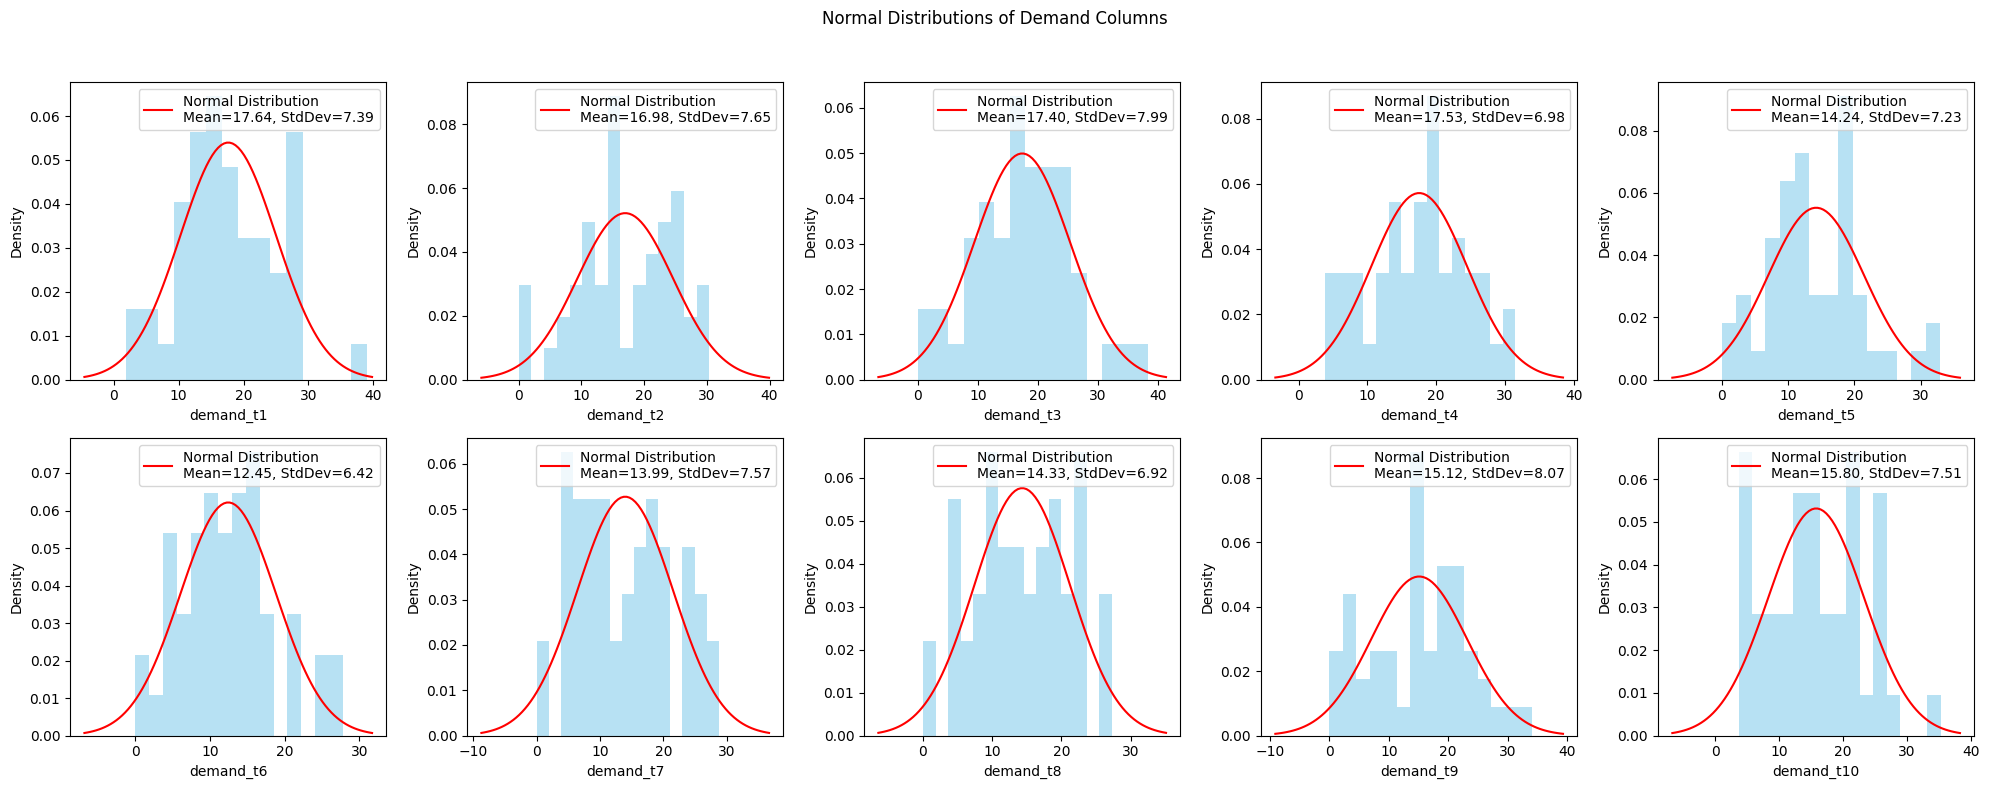

In [29]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [30]:
demand_df.cov()

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1   55.766964  10.782769  34.541064  15.610473 -22.067285 -15.672412   
demand_t2   10.782769  59.641856  39.946127   8.752040 -26.123491  -9.565768   
demand_t3   34.541064  39.946127  65.129320   4.508503 -27.055220 -22.527053   
demand_t4   15.610473   8.752040   4.508503  49.683684 -26.033199  -4.309596   
demand_t5  -22.067285 -26.123491 -27.055220 -26.033199  53.289792  16.426599   
demand_t6  -15.672412  -9.565768 -22.527053  -4.309596  16.426599  42.039488   
demand_t7  -14.237829 -23.130424 -41.512849  13.634396  15.589577  34.023116   
demand_t8   -5.055418  12.072126  10.341245 -33.861804  16.594622  17.618905   
demand_t9  -37.621091  13.294656 -25.470477  17.901233  -4.041189  -0.831385   
demand_t10   9.116602   5.493815   2.799311  25.764294 -10.585068   4.447678   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1  -14.237829  -5.055418 -37.621091    9.116602  
demand_t2  -23.130424  12.072126  13.294656    5.493815  
demand_t3  -41.512849  10.341245 -25.470477    2.799311  
demand_t4   13.634396 -33.861804  17.901233   25.764294  
demand_t5   15.589577  16.594622  -4.041189  -10.585068  
demand_t6   34.023116  17.618905  -0.831385    4.447678  
demand_t7   58.426763  -8.649191  13.106096   23.219900  
demand_t8   -8.649191  48.903194 -13.356216   -2.123279  
demand_t9   13.106096 -13.356216  66.464454   19.876099  
demand_t10  23.219900  -2.123279  19.876099   57.502926

In [31]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.568140  10.004661   2.628399  15.853017   1.284401   6.202917   
demand_t2   10.004661   4.133804   0.462692  11.209802   4.988853   2.010715   
demand_t3    2.628399   0.462692   3.530349  10.228850   2.523465   7.776303   
demand_t4   15.853017  11.209802  10.228850   3.252114   3.059817   0.265908   
demand_t5    1.284401   4.988853   2.523465   3.059817   0.018819   5.156850   
demand_t6    6.202917   2.010715   7.776303   0.265908   5.156850  21.507331   
demand_t7    8.734762   1.011158   8.855333   4.509445   0.973790   5.612774   
demand_t8    9.819686   7.858623   9.738607   0.244588   0.931507  12.729927   
demand_t9    7.847976   6.009551   1.480574  12.537210   5.263269  21.754057   
demand_t10  10.275277   8.444497  10.375493  12.402330   4.628138   4.393941   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    8.734762   9.819686   7.847976   10.275277  
demand_t2    1.011158   7.858623   6.009551    8.444497  
demand_t3    8.855333   9.738607   1.480574   10.375493  
demand_t4    4.509445   0.244588  12.537210   12.402330  
demand_t5    0.973790   0.931507   5.263269    4.628138  
demand_t6    5.612774  12.729927  21.754057    4.393941  
demand_t7    1.326413  10.799517  13.718487    4.399167  
demand_t8   10.799517   4.716168   1.028514    9.307942  
demand_t9   13.718487   1.028514   2.382624    2.269641  
demand_t10   4.399167   9.307942   2.269641    0.877051

### Validate the corr matrix of damand_df is close to original setting


In [32]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.000000   0.186968   0.573138   0.296566  -0.404798  -0.323682   
demand_t2    0.186968   1.000000   0.640930   0.160778  -0.463376  -0.191036   
demand_t3    0.573138   0.640930   1.000000   0.079257  -0.459241  -0.430514   
demand_t4    0.296566   0.160778   0.079257   1.000000  -0.505940  -0.094298   
demand_t5   -0.404798  -0.463376  -0.459241  -0.505940   1.000000   0.347054   
demand_t6   -0.323682  -0.191036  -0.430514  -0.094298   0.347054   1.000000   
demand_t7   -0.249430  -0.391834  -0.672959   0.253060   0.279387   0.686498   
demand_t8   -0.096805   0.223532   0.183238  -0.686965   0.325070   0.388581   
demand_t9   -0.617943   0.211158  -0.387128   0.311517  -0.067904  -0.015728   
demand_t10   0.160990   0.093811   0.045742   0.482021  -0.191217   0.090461   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   -0.249430  -0.096805  -0.617943    0.160990  
demand_t2   -0.391834   0.223532   0.211158    0.093811  
demand_t3   -0.672959   0.183238  -0.387128    0.045742  
demand_t4    0.253060  -0.686965   0.311517    0.482021  
demand_t5    0.279387   0.325070  -0.067904   -0.191217  
demand_t6    0.686498   0.388581  -0.015728    0.090461  
demand_t7    1.000000  -0.161808   0.210316    0.400599  
demand_t8   -0.161808   1.000000  -0.234272   -0.040040  
demand_t9    0.210316  -0.234272   1.000000    0.321508  
demand_t10   0.400599  -0.040040   0.321508    1.000000

In [33]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


0         1         2         3         4         5         6  \
0  1.000000  0.354243  0.555784  0.587411 -0.387774 -0.161484 -0.099073   
1  0.354243  1.000000  0.645671  0.344249 -0.533962 -0.118714 -0.366601   
2  0.555784  0.645671  1.000000  0.259728 -0.428492 -0.236520 -0.551543   
3  0.587411  0.344249  0.259728  1.000000 -0.433716 -0.078962  0.166233   
4 -0.387774 -0.533962 -0.428492 -0.433716  1.000000  0.371399  0.300310   
5 -0.161484 -0.118714 -0.236520 -0.078962  0.371399  1.000000  0.658292   
6 -0.099073 -0.366601 -0.551543  0.166233  0.300310  0.658292  1.000000   
7 -0.275944  0.072230  0.010563 -0.631022  0.294020  0.520508  0.038941   
8 -0.488891  0.109958 -0.414246  0.089139 -0.153719 -0.341738 -0.009772   
9 -0.020925 -0.049126 -0.128709  0.244177 -0.108549  0.147419  0.485870   

          7         8         9  
0 -0.275944 -0.488891 -0.020925  
1  0.072230  0.109958 -0.049126  
2  0.010563 -0.414246 -0.128709  
3 -0.631022  0.089139  0.244177  
4  0.294020 -0.153719 -0.108549  
5  0.520508 -0.341738  0.147419  
6  0.038941 -0.009772  0.485870  
7  1.000000 -0.203659  0.130487  
8 -0.203659  1.000000  0.355112  
9  0.130487  0.355112  1.000000

### Split test and train demand_df


In [34]:
demand_df_train, demand_df_test = (
    demand_df[: int(data_size * train_size)],
    demand_df[int(data_size * train_size) :],
)
print(f"demand_df_train size: {demand_df_train.shape}")
print(f"demand_df_test size: {demand_df_test.shape}")

demand_df_test.reset_index(drop=True, inplace=True)

demand_df_train size: (40, 10)
demand_df_test size: (10, 10)


In [35]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [36]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [37]:
Q_star = calculate_Q_star(demand_df_train, service_level=0.95)

mean of sum: 157.87903781155435
std of sum: 25.32678403729653
95.0 percentile of sum: 199.5378903943182


## Data3: Qk hat df


### Functions


In [38]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [39]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [40]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    print(f"        mean_Y: {mean_Y}")
    print(f"        sd_Y: {sd_Y}")
    print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [41]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    print(f"mu_matrix: {mu_matrix}")
    print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [42]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            print(f"    x_observed: {x_observed}")
            print(f"    mu_cond: {mu_cond}")
            print(f"    sigma_cond: \n{sigma_cond}")
            print(f"    Qk_hat: {Qk_hat}")
            print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [43]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [44]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [45]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
        mean_Y: 69.23076923076923
        sd_Y: 4.260733053577301
    percentile_95_Y: 76.23905144741786
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

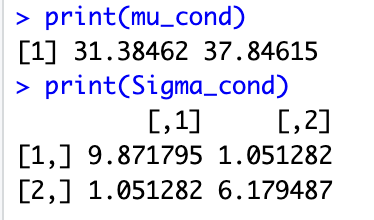
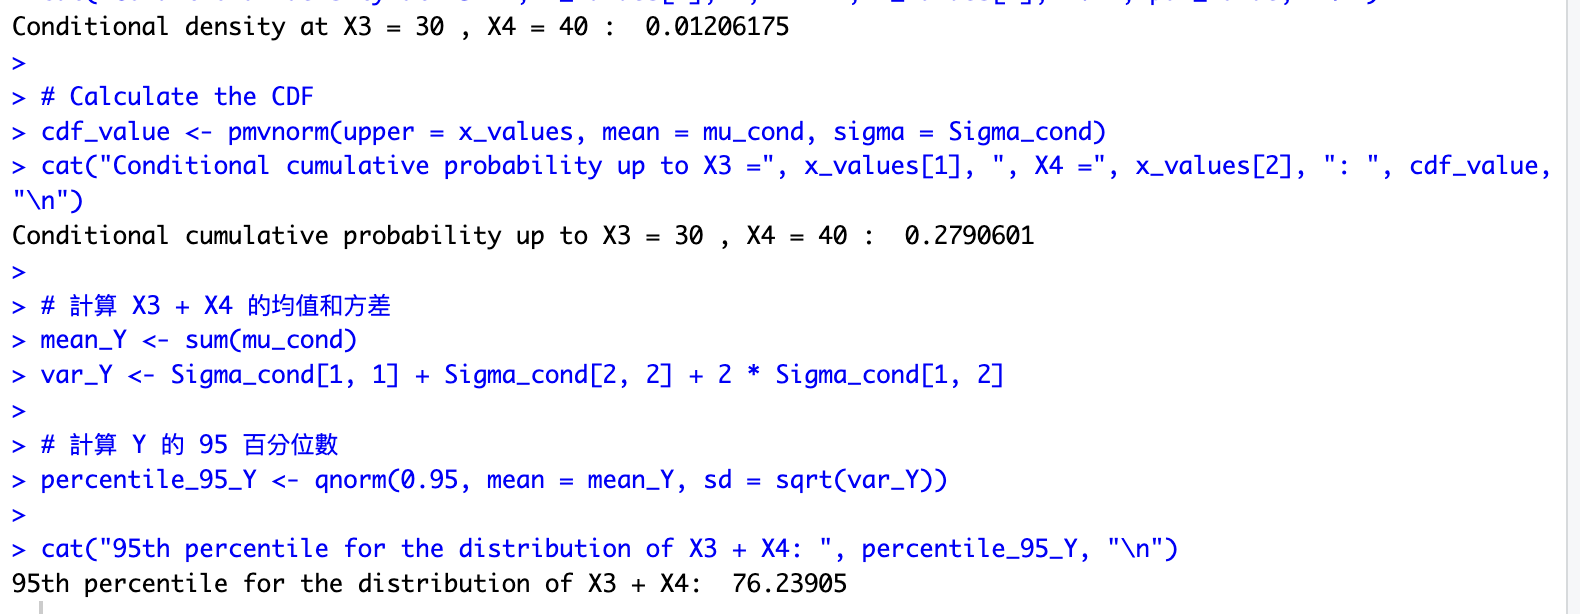


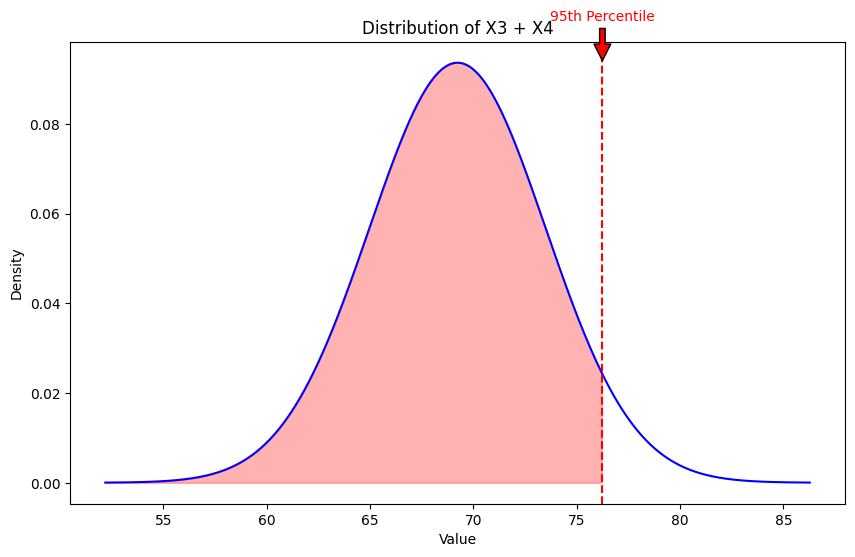

In [46]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


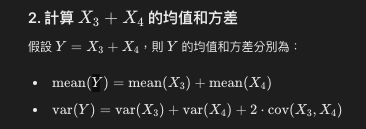


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [47]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.014943323554928
模擬計算的Y的方差: 2.961260737816822


### Calculate Qk hat for 2~T-1 of demand_df_train


In [48]:
demand_df_train

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   21.628301   0.000000   4.140547  14.794692  32.952061  17.580815   
1   26.776223  14.349939  17.000444  15.770674  18.548975  21.409526   
2   39.015924  28.836781  38.348790  27.637901   8.086327   2.845409   
3   11.598733  24.950174  15.869886   5.372479  16.790273  14.914910   
4   13.098249  12.011826  16.324598  19.408115  13.968583   0.000000   
5   16.870007  24.713646  24.204669  14.020862  10.292790  11.518817   
6    8.339548  24.578702  25.419531  15.268904  10.785589   7.878314   
7   12.897472  16.162037  16.396734  19.253830  20.497885  24.811252   
8   27.035954  24.962339  27.672613  13.750945   2.556598  14.952471   
9   22.463167  13.582489  20.818504  13.499535  15.046224  12.401391   
10   2.175715   0.000000   0.000000   8.980925  18.415047  15.679114   
11  12.047023   0.000000   0.000000   7.239187  28.899654  17.241392   
12  13.141306   9.370526   8.791118  19.427896  19.288655  10.834549   
13  21.864248  17.005986  22.685272  12.859976  12.789747   9.544221   
14  26.948029  10.586702  25.702509  18.878185   5.164556   3.824112   
15  15.395007  23.033233  19.508439   3.875423  19.615005  10.572267   
16  28.335755  18.790605  23.357549   6.534795  12.123297  12.210429   
17  11.643432  14.379079  10.522533  18.512794  17.435063  27.795343   
18   5.723222  26.476989  21.168103  16.001752  16.526143   6.230008   
19  22.227637  30.389835  24.627904  18.349065  11.394568  14.490510   
20  24.824048  14.182223  19.258640  28.408800  20.884268  12.373145   
21  13.406453  15.397041  12.139559  18.708534  22.317679  24.395873   
22  17.293853  21.590021  16.700851  22.374612  12.403296   7.829604   
23  24.534162  22.954822  15.992604  24.613209   7.178288   5.572604   
24  16.422545  15.912030  21.859205  23.807423  17.692969   8.542883   
25  12.319538   8.397246  12.357421  17.128546  13.759495  15.672482   
26  17.207631  25.367601  16.176612  23.245387   8.271251   8.029378   
27  16.514388  15.906502   3.954046  30.706518  10.767977   7.123747   
28  16.095546   7.617504  19.173828  12.619443  17.967923   9.773403   
29  23.575593  24.416007  18.332358  26.928863   3.350522  20.930862   
30  21.465770  22.032454  32.319985  16.933798  12.132272  13.065885   
31  14.106839  19.142243  20.675733   9.448357  18.882570  16.584709   
32  14.470866  28.570515  18.737620  20.155615  10.833259  10.821148   
33   1.818108  20.756198  10.115090  22.345108  12.813436  26.434711   
34   5.726470  11.949030   8.605253   9.207319  18.791679  13.050483   
35  14.571100  23.835885  20.108695  31.505264   8.305727  14.725176   
36  16.978836   9.174192  11.170106  19.348628  18.738221  21.312541   
37  17.975950  13.606940   8.854614  22.234803  12.207279  16.229842   
38  14.997624  27.577241  33.357254  13.076502  18.519012   4.006902   
39  10.841472  23.116619  13.766480   8.865426  20.814289  16.847575   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   28.779684  12.948621   4.257279   21.063419  
1   20.580347  21.779295   3.149199   15.268276  
2    4.915871  12.413783   8.949089   26.533160  
3   12.752493  26.317817  18.598380   13.990928  
4    4.004635   0.000000  21.035061    4.466441  
5    8.924556  20.506724  14.015789   12.841424  
6    7.473511  17.906391  22.168582   18.965401  
7   23.357246  21.838296  17.816820   26.805897  
8   12.086433  27.274418   8.934028   21.344027  
9   16.861946  12.320182   0.238896    8.544022  
10  17.778682   8.409496  25.272118    8.758444  
11  20.938378  15.602594   5.379306    3.662172  
12  23.778078   0.631211  18.819244   13.554523  
13   9.237258  16.921415   9.566006   11.621436  
14   4.024678   9.054851   3.711701   17.887787  
15   6.227981  23.292854  10.670875    7.410580  
16  11.018282  20.942456   0.000000    9.689252  
17  24.370603  19.121483  15.207288   16.801672  
18   7.392028  19.074638  31.479587   27.421621  
19   6.345097  18.073256  14.712353   14.301498  
2

In [49]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

mu_matrix: [16.85929352 17.64208003 17.40539246 17.27750222 14.9452113  13.25144508
 14.55940354 14.853123   15.43293702 15.65264964]
covariance_matrix: 
[[ 5.64723956e+01  1.18594082e+01  3.43466372e+01  1.38426555e+01
  -1.66913909e+01 -1.27935054e+01 -1.49262702e+01 -3.84331959e-02
  -4.09863740e+01  4.05616662e+00]
 [ 1.18594082e+01  6.46671989e+01  4.64620150e+01  1.05481991e+01
  -2.94529918e+01 -1.23617948e+01 -3.03585130e+01  1.45910687e+01
   1.43480026e+01  6.85598630e+00]
 [ 3.43466372e+01  4.64620150e+01  7.16692411e+01  4.24824557e+00
  -2.64983973e+01 -2.42997906e+01 -4.93872371e+01  1.40154826e+01
  -2.54886928e+01 -1.68082440e+00]
 [ 1.38426555e+01  1.05481991e+01  4.24824557e+00  4.77523725e+01
  -1.82898076e+01 -4.27643167e+00  1.08492715e+01 -2.84351533e+01
   2.14090919e+01  2.55695743e+01]
 [-1.66913909e+01 -2.94529918e+01 -2.64983973e+01 -1.82898076e+01
   3.92999709e+01  1.34369964e+01  1.87455199e+01  5.72692099e+00
  -6.81809319e+00 -7.23117239e+00]
 [-1.279350

In [50]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

mu_matrix: [17.63876624 16.98263282 17.40056963 17.5274631  14.24154567 12.44973395
 13.98906034 14.33363245 15.11520152 15.80431854]
covariance_matrix: 
[[ 55.76696393  10.78276942  34.54106363  15.61047299 -22.06728496
  -15.67241175 -14.237829    -5.05541756 -37.62109112   9.11660212]
 [ 10.78276942  59.64185557  39.94612678   8.75203978 -26.12349146
   -9.56576781 -23.13042397  12.07212579  13.29465588   5.49381548]
 [ 34.54106363  39.94612678  65.12932033   4.50850286 -27.05521991
  -22.52705301 -41.51284936  10.34124515 -25.4704774    2.79931095]
 [ 15.61047299   8.75203978   4.50850286  49.6836842  -26.03319918
   -4.3095965   13.63439613 -33.8618042   17.90123324  25.7642936 ]
 [-22.06728496 -26.12349146 -27.05521991 -26.03319918  53.2897921
   16.42659886  15.58957722  16.5946224   -4.04118905 -10.58506841]
 [-15.67241175  -9.56576781 -22.52705301  -4.3095965   16.42659886
   42.03948795  34.02311649  17.61890478  -0.83138518   4.4476775 ]
 [-14.237829   -23.13042397 -41.51284

In [51]:
Qk_hat_df

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0   196.730270  165.826129  170.767696  164.483383  180.630479  172.720206   
1   199.607045  188.456931  191.182679  183.697352  186.587644  196.303469   
2   206.446866  213.224977  208.277036  211.053997  219.611235  207.365540   
3   191.125522  199.996131  202.214532  186.856165  179.846442  173.869865   
4   191.963485  181.266862  175.346405  178.657669  172.404570  142.544474   
5   194.071228  201.084336  196.725560  191.340168  183.094855  178.608682   
6   189.304215  198.557499  187.817342  188.253073  180.342661  169.096824   
7   191.851286  187.351065  183.955334  185.889249  192.387174  206.002113   
8   199.752189  204.225613  201.950739  192.727617  174.245381  182.336967   
9   197.196812  186.145061  181.549866  175.308539  170.487584  167.247117   
10  185.859726  160.519193  158.953480  153.998174  135.612063  127.275770   
11  191.376036  163.212223  167.333128  155.894059  156.266144  146.897549   
12  191.987546  177.371607  178.292770  179.660249  179.193437  163.640465   
13  196.862122  191.045691  186.232560  179.178478  171.833760  164.248186   
14  199.703054  182.937237  173.418044  173.618522  157.006127  145.588989   
15  193.246965  198.196274  197.215043  180.440732  178.311494  166.094808   
16  200.478547  195.451011  194.773613  177.587899  166.686793  165.097245   
17  191.150500  184.371600  185.750255  185.870845  183.778965  201.105703   
18  187.842153  200.651668  194.474165  194.733472  196.142656  175.637322   
19  197.065193  210.942169  212.912676  207.996493  208.342527  207.393615   
20  198.516126  187.676266  186.604703  194.473057  210.919847  202.824505   
21  192.135716  186.358342  187.585269  187.363865  195.073937  204.568652   
22  194.308083  196.579512  198.931687  200.525371  198.589254  181.497871   
23  198.354131  200.573578  208.795682  208.702645  201.255259  181.283243   
24  193.821176  187.942943  180.214878  187.487711  194.827981  181.969547   
25  191.528323  175.707745  171.469903  172.391161  161.267306  160.230290   
26  194.259900  202.143772  207.519039  208.679344  201.621576  185.052967   
27  193.872500  187.959822  200.600610  208.590865  203.623810  178.555260   
28  193.638442  175.584500  165.274906  162.373411  157.717219  148.836656   
29  197.818461  202.473447  208.446523  211.682714  200.474879  212.499087   
30  196.639444  198.372114  185.692545  185.150490  184.579399  188.515907   
31  192.527108  192.089307  186.489075  177.974184  177.228795  178.438730   
32  192.730534  206.134884  209.128112  208.176709  204.754403  193.232589   
33  185.659887  191.124125  191.487987  198.113541  191.320885  205.027405   
34  187.843968  179.162850  177.714756  170.695254  161.294299  149.735273   
35  192.786547  199.158780  197.548202  210.746727  209.891919  208.555317   
36  194.132044  178.128121  178.431429  178.864290  178.834786  185.426502   
37  194.689254  184.957054  191.370075  192.149242  184.295892  180.792919   
38  193.024898  204.809342  190.863493  187.815006  196.589574  179.319936   
39  190.702347  197.077351  200.043866  188.593440  189.534567  184.422320   
40  196.145480  196.707565  207.023535  210.456976  206.749142  198.731825   
41  200.603501  196.128688  190.605383  182.723210  169.666608  159.211866   
42  190.636315  170.800910  169.398866  158.771382  157.851148  146.819163   
43  196.322581  180.880288  179.661601  186.436603  179.893920  174.788955   
44  195.098993  185.447093  186.719804  186.851241  180.419352  159.213240   
45  198.344736  189.412117  185.187612  187.117985  170.374207  180.329888   
46  190.948148  180.181194  176.949876  182.070403  154.348563  143.770878   
47  200.314121  202.907750  205.153755  199.312080  178.405977  156.215852   
48  193.428558  186.821950  184.874792  169.882511  186.405537  169.331067   
49  200.589327  178.784185  170.721462  176.954892  172.103367  160.564783   

     Qk_hat_k8   Qk_hat_k9

### Plot the distribuction


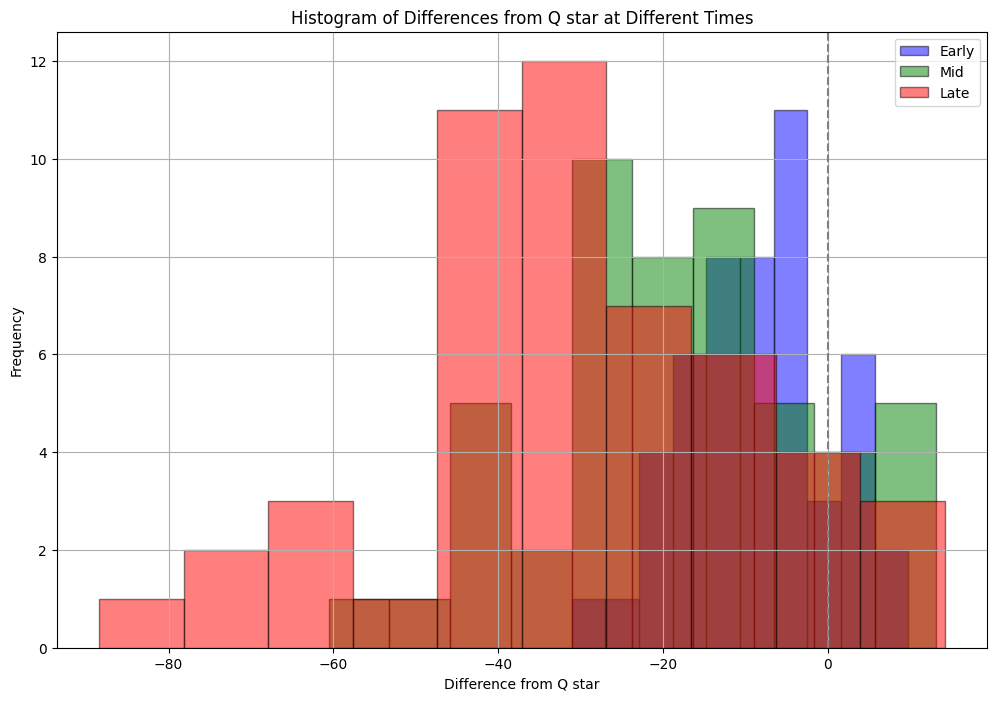

Q_star is: 199.5378903943182
Early bias: -8.55380618586113
Mid bias: -17.80498874912759
Late bias: -30.677114450352974


In [52]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

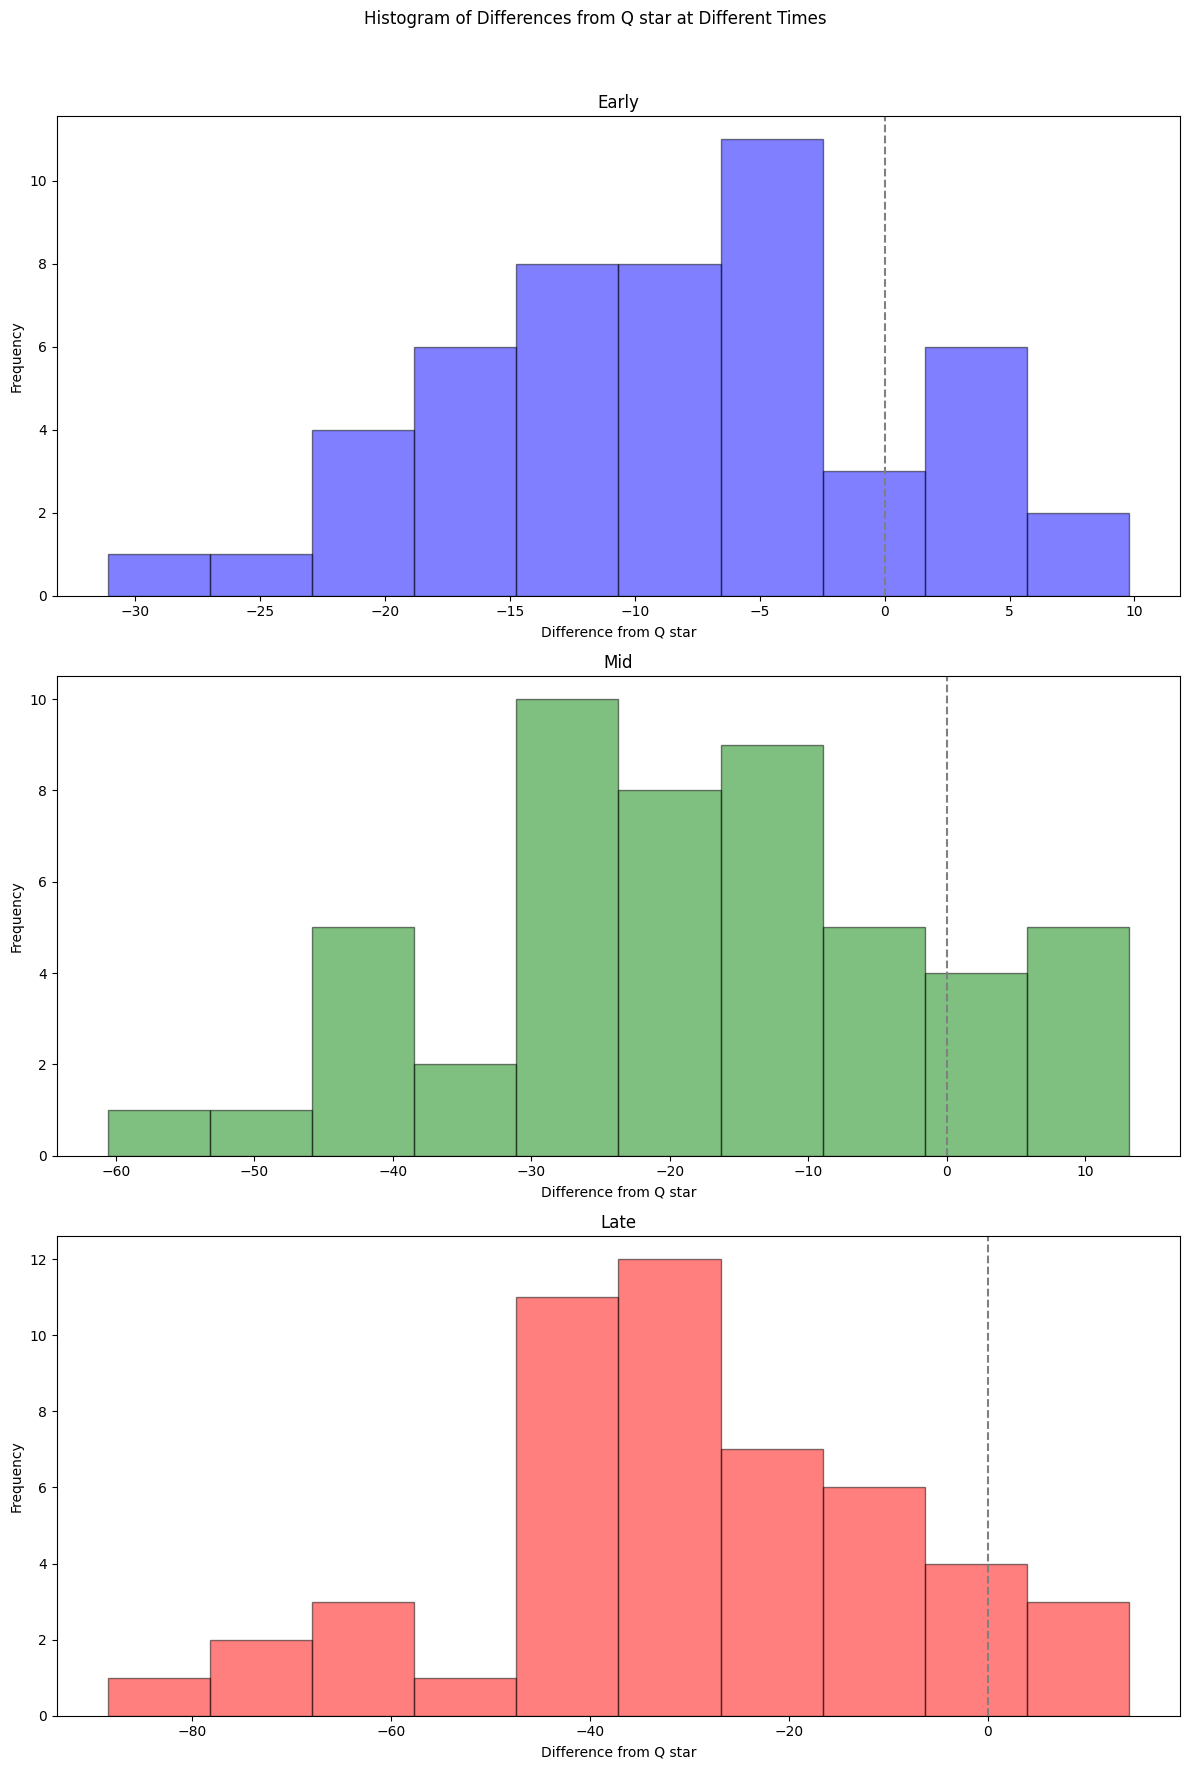

In [53]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## One-time Procurement


In [54]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## (1)Grid for Fixed F & Fixed Rk


In [55]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": Q0,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
    }

    return result_df, stimulation_result

In [56]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    print(f"Q_star: {Q_star}")
    results_list = []
    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## (2)Grid for Fixed Rk & Flexible F


In [57]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            ## 只會有一個 R 為 1
            model.addConstr(R_vars[i, assigned_R] == 1, name=f"Set_R_{i}_0_To_1")
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for key, alpha in alphas.items()])

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (assigned_R+1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(assigned_R+1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [58]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is T={assigned_T} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )

        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:

            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                alpha_values,
                F_vars,
                Q0_vars,
                Q1_vars,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(assigned_T)
            results_dict["R"].append([x - 2 for x in all_Rs])
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["alpha_values"].append(alpha_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R": [x - 2 for x in all_Rs],
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## (4)Grid for Fixed F & Flexible Rk(s6)


In [59]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [60]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                }

            print(f"beta_values: \n{beta_values}")

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## (3)Fully flexible F & Rk


### (5)Simple beta with softmax


In [61]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [62]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [63]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(softmax)
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None
        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [64]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


這是將 tau = beta + f 進行計算的部分


In [65]:
def __fully_flexible_simple_beta_with_softmax_3(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept
        # gamma = model.addVar(1, name="gamma")  # gamma

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            # model.addGenConstrMax(Q1_vars[i], [Q_hat_adjusteds[i]], 0.0, name=f"Q1_var_{i}")
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )  # 計算 Q1 = max(Q_hat_adjusted, 0) 的線性替代
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [66]:
def fully_flexible_simple_beta_with_softmax_3(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_3(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

### (7)Beta with softmax


In [67]:
def __fully_flexible_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)

            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [68]:
def fully_flexible_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

# Testing Utils


## (1)Grid for Fixed F & Fixed Rk


In [69]:
# put best F and R into the model
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## (2)Grid for Fixed Rk & Flexible F


In [70]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

## (4)Grid for Fixed F & Flexible Rk(s6)


In [71]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

## (3)Fully flexible F & Rk


### (5)Simple beta with softmax


In [72]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [73]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [74]:
# import alpha and beta
# put them to compute every R and F


def cal_test_fully_flexible_simple_beta_with_softmax_3(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

### (7)Beta with softmax


In [75]:
def cal_test_fully_flexible_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

# High Margin(P-C High)


## Setting reasonable parameters


In [76]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202411060137

In [77]:
model_prefix = "high"
status = "train"

salvage_value = 0
cost = 200
price = 1000


service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.8


In [78]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 157.87903781155435
std of sum: 25.32678403729653
80.0 percentile of sum: 179.19459703545866
Q_star: 179.19459703545866


In [79]:
demand_df_train

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   21.628301   0.000000   4.140547  14.794692  32.952061  17.580815   
1   26.776223  14.349939  17.000444  15.770674  18.548975  21.409526   
2   39.015924  28.836781  38.348790  27.637901   8.086327   2.845409   
3   11.598733  24.950174  15.869886   5.372479  16.790273  14.914910   
4   13.098249  12.011826  16.324598  19.408115  13.968583   0.000000   
5   16.870007  24.713646  24.204669  14.020862  10.292790  11.518817   
6    8.339548  24.578702  25.419531  15.268904  10.785589   7.878314   
7   12.897472  16.162037  16.396734  19.253830  20.497885  24.811252   
8   27.035954  24.962339  27.672613  13.750945   2.556598  14.952471   
9   22.463167  13.582489  20.818504  13.499535  15.046224  12.401391   
10   2.175715   0.000000   0.000000   8.980925  18.415047  15.679114   
11  12.047023   0.000000   0.000000   7.239187  28.899654  17.241392   
12  13.141306   9.370526   8.791118  19.427896  19.288655  10.834549   
13  21.864248  17.005986  22.685272  12.859976  12.789747   9.544221   
14  26.948029  10.586702  25.702509  18.878185   5.164556   3.824112   
15  15.395007  23.033233  19.508439   3.875423  19.615005  10.572267   
16  28.335755  18.790605  23.357549   6.534795  12.123297  12.210429   
17  11.643432  14.379079  10.522533  18.512794  17.435063  27.795343   
18   5.723222  26.476989  21.168103  16.001752  16.526143   6.230008   
19  22.227637  30.389835  24.627904  18.349065  11.394568  14.490510   
20  24.824048  14.182223  19.258640  28.408800  20.884268  12.373145   
21  13.406453  15.397041  12.139559  18.708534  22.317679  24.395873   
22  17.293853  21.590021  16.700851  22.374612  12.403296   7.829604   
23  24.534162  22.954822  15.992604  24.613209   7.178288   5.572604   
24  16.422545  15.912030  21.859205  23.807423  17.692969   8.542883   
25  12.319538   8.397246  12.357421  17.128546  13.759495  15.672482   
26  17.207631  25.367601  16.176612  23.245387   8.271251   8.029378   
27  16.514388  15.906502   3.954046  30.706518  10.767977   7.123747   
28  16.095546   7.617504  19.173828  12.619443  17.967923   9.773403   
29  23.575593  24.416007  18.332358  26.928863   3.350522  20.930862   
30  21.465770  22.032454  32.319985  16.933798  12.132272  13.065885   
31  14.106839  19.142243  20.675733   9.448357  18.882570  16.584709   
32  14.470866  28.570515  18.737620  20.155615  10.833259  10.821148   
33   1.818108  20.756198  10.115090  22.345108  12.813436  26.434711   
34   5.726470  11.949030   8.605253   9.207319  18.791679  13.050483   
35  14.571100  23.835885  20.108695  31.505264   8.305727  14.725176   
36  16.978836   9.174192  11.170106  19.348628  18.738221  21.312541   
37  17.975950  13.606940   8.854614  22.234803  12.207279  16.229842   
38  14.997624  27.577241  33.357254  13.076502  18.519012   4.006902   
39  10.841472  23.116619  13.766480   8.865426  20.814289  16.847575   

    demand_t7  demand_t8  demand_t9  demand_t10  
0   28.779684  12.948621   4.257279   21.063419  
1   20.580347  21.779295   3.149199   15.268276  
2    4.915871  12.413783   8.949089   26.533160  
3   12.752493  26.317817  18.598380   13.990928  
4    4.004635   0.000000  21.035061    4.466441  
5    8.924556  20.506724  14.015789   12.841424  
6    7.473511  17.906391  22.168582   18.965401  
7   23.357246  21.838296  17.816820   26.805897  
8   12.086433  27.274418   8.934028   21.344027  
9   16.861946  12.320182   0.238896    8.544022  
10  17.778682   8.409496  25.272118    8.758444  
11  20.938378  15.602594   5.379306    3.662172  
12  23.778078   0.631211  18.819244   13.554523  
13   9.237258  16.921415   9.566006   11.621436  
14   4.024678   9.054851   3.711701   17.887787  
15   6.227981  23.292854  10.670875    7.410580  
16  11.018282  20.942456   0.000000    9.689252  
17  24.370603  19.121483  15.207288   16.801672  
18   7.392028  19.074638  31.479587   27.421621  
19   6.345097  18.073256  14.712353   14.301498  
2

In [80]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

mu_matrix: [16.85929352 17.64208003 17.40539246 17.27750222 14.9452113  13.25144508
 14.55940354 14.853123   15.43293702 15.65264964]
covariance_matrix: 
[[ 5.64723956e+01  1.18594082e+01  3.43466372e+01  1.38426555e+01
  -1.66913909e+01 -1.27935054e+01 -1.49262702e+01 -3.84331959e-02
  -4.09863740e+01  4.05616662e+00]
 [ 1.18594082e+01  6.46671989e+01  4.64620150e+01  1.05481991e+01
  -2.94529918e+01 -1.23617948e+01 -3.03585130e+01  1.45910687e+01
   1.43480026e+01  6.85598630e+00]
 [ 3.43466372e+01  4.64620150e+01  7.16692411e+01  4.24824557e+00
  -2.64983973e+01 -2.42997906e+01 -4.93872371e+01  1.40154826e+01
  -2.54886928e+01 -1.68082440e+00]
 [ 1.38426555e+01  1.05481991e+01  4.24824557e+00  4.77523725e+01
  -1.82898076e+01 -4.27643167e+00  1.08492715e+01 -2.84351533e+01
   2.14090919e+01  2.55695743e+01]
 [-1.66913909e+01 -2.94529918e+01 -2.64983973e+01 -1.82898076e+01
   3.92999709e+01  1.34369964e+01  1.87455199e+01  5.72692099e+00
  -6.81809319e+00 -7.23117239e+00]
 [-1.279350

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0   181.795741  152.555646  157.515719  152.456868  169.250116  160.538970   
1   184.999157  174.918364  178.075145  171.162570  175.065235  186.587708   
2   192.615602  199.741345  194.391947  199.776969  204.915194  192.976648   
3   175.554604  185.382089  189.342577  171.449343  170.637296  164.311721   
4   176.487714  167.178429  160.597474  165.779829  159.973306  129.096095   
5   178.834779  186.722322  182.716412  177.093617  171.466667  168.392863   
6   173.526499  183.805888  172.659195  173.420138  167.821661  158.754064   
7   176.362775  173.106987  169.794485  173.097662  180.316400  198.826675   
8   185.160781  190.324794  188.350638  178.815534  162.613030  172.701957   
9   182.315256  172.434169  167.121947  161.446653  157.915697  155.582522   
10  169.690907  146.349431  144.496106  139.719549  125.659627  118.261500   
11  175.833563  149.498804  153.903518  142.049513  146.363665  135.905582   
12  176.514507  163.378313  164.643476  167.648855  168.120245  152.738504   
13  181.942564  177.186378  171.886751  165.018540  159.478262  152.207508   
14  185.106068  169.539327  158.040014  160.514732  142.883535  132.150768   
15  177.916925  183.825335  183.729934  164.503908  167.898332  154.225756   
16  185.969614  181.827934  181.236475  162.613701  155.278543  152.872433   
17  175.582419  170.132427  172.354319  173.503660  173.192919  195.383706   
18  171.898428  185.712161  180.170588  180.443690  184.653415  164.813532   
19  182.168692  196.627657  200.229971  195.222982  197.461013  197.847100   
20  183.784370  174.053366  172.821550  184.113277  197.568725  191.180654   
21  176.679501  172.164773  174.205555  175.010641  184.025851  197.142270   
22  179.098528  182.347252  185.983514  188.885200  187.787432  170.643443   
23  183.603982  186.627899  196.946555  198.247150  191.346070  169.889452   
24  178.556336  173.870644  165.301793  175.227642  181.165461  170.272549   
25  176.003142  161.710785  156.882666  159.352820  149.456409  151.027135   
26  179.044874  187.774304  195.233010  197.409738  191.775174  175.050196   
27  178.613487  173.891964  189.241931  200.028336  194.805833  168.554878   
28  178.352853  161.789601  149.613892  147.816798  144.167193  136.473296   
29  183.007489  188.431924  196.253702  201.385983  190.150863  205.967281   
30  181.694602  184.317115  170.152197  170.762529  170.123747  177.619107   
31  177.115333  177.796036  172.054352  162.808348  165.367595  168.473358   
32  177.341857  191.525942  196.531005  195.833028  194.718439  183.873389   
33  169.468378  176.205838  178.107462  186.021845  181.446213  201.160974   
34  171.900449  164.735839  163.717498  156.077679  151.162852  139.872793   
35  177.404230  184.721446  183.978986  200.429970  197.930604  200.857750   
36  178.902501  164.319157  164.681099  166.838862  167.283575  176.907537   
37  179.522979  171.037859  178.847789  181.248576  174.341617  172.089525   
38  177.669645  190.259782  175.277005  172.166149  182.453861  165.946947   
39  175.083380  182.492964  187.234236  174.052419  180.078855  175.196225   

     Qk_hat_k8   Qk_hat_k9  
0   163.632027  160.274141  
1   183.626785  181.802124  
2   195.123652  191.944736  
3   164.574937  164.489516  
4   122.338222  106.291602  
5   168.298371  167.941450  
6   163.056951  166.484626  
7   197.759115  200.717325  
8   177.217051  187.051006  
9   163.866402  146.891716  
10  111.516113   97.846544  
11  128.890329  124.933798  
12  161.990499  137.444472  
13  152.289436  147.978844  
14  128.785391  125.531885  
15  149.984498  142.432002  
16  156.197971  143.486825  
17  188.401528  182.101629  
18  165.485725  176.505182  
19  184.903544  171.192627  
20  189.570827  189.456478  
21  198.483089  197.409928  
22  165.269054  147.689511  
23  151.196654  151.785347  
24  164.564229  167.392226  
25  147.768764  158.506322  
26  167.586649  150.669

## Strategies


### One-time procurement strategy


In [81]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/40 with initial inventory Q_star=179.19459703545866
--------------------------------------------------
Day 1
Demand      : 21.628300603338065
Sales       : 21.628300603338065
Loss        : 0
Left        : 157.5662964321206
Inventory   : 157.5662964321206
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 0.0
Sales       : 0.0
Loss        : 0
Left        : 157.5662964321206
Inventory   : 157.5662964321206
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 4.140547394978338
Sales       : 4.140547394978338
Loss        : 0
Left        : 153.42574903714225
Inventory   : 153.42574903714225
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 14.794692242241718
Sales       : 14.794692242241718
Loss        : 0
Left        : 138.63105679490053
Inventory   : 138.631056794

In [82]:
baseline_stimulation_df

losses      lefts  operation_profits        profits
0    0.000000  21.049178      126516.334877  122306.499189
1    0.000000   4.561700      139706.317405  138793.977349
2   18.388438   0.000000      143355.677628  128644.926913
3    0.000000  18.038524      128924.858727  125317.154001
4    0.000000  74.877088       83454.006918   68478.589240
5    0.000000  21.285314      126327.426397  122070.363590
6    0.000000  20.410124      127027.578041  122945.553144
7   20.642875   0.000000      143355.677628  126841.377931
8    1.375229   0.000000      143355.677628  142255.494205
9    0.000000  43.418242      108621.084238   99937.435891
10   0.000000  73.725055       84375.633418   69630.622366
11   0.000000  68.184891       88807.765189   75170.787079
12   0.000000  41.557491      110109.684859  101798.186667
13   0.000000  35.099032      115276.451988  108256.645578
14   0.000000  53.411487      100626.488067   89944.190676
15   0.000000  39.592934      111681.330809  103762.744104
16   0.000000  36.192176      114401.936498  107163.501216
17   0.000000   3.405307      140631.432352  139950.371032
18   0.000000   1.700507      141995.272064  141655.170673
19   0.000000   4.282876      139929.376968  139072.801802
20   7.097058   0.000000      143355.677628  137678.031343
21   5.620386   0.000000      143355.677628  138859.369171
22   0.000000  43.267391      108741.764532  100088.286258
23   0.000000  40.846239      110678.686441  102509.438644
24   0.000000  17.316477      129502.496100  126039.200718
25   0.000000  24.884600      123447.997990  118471.078080
26   0.000000  38.708083      112389.210974  104647.594311
27   7.131996   0.000000      143355.677628  137650.080649
28   0.000000  66.202262       90393.868105   77153.415724
29  19.317633   0.000000      143355.677628  127901.571135
30   0.000000  24.065264      124103.466386  119290.413576
31   0.000000  32.227777      117573.455761  111127.900294
32   0.000000  10.330933      135090.931245  133024.744649
33   0.000000   1.874435      141856.129820  141481.242868
34   0.000000  27.872362      121057.788307  115483.315976
35   8.308578   0.000000      143355.677628  136708.815132
36   0.000000  12.496142      133358.763709  130859.535229
37   0.000000   9.657589      135629.606421  133698.088619
38   0.000000  28.177284      120813.850714  115178.393985
39   0.000000   1.785798      141927.039076  141569.879438

### (1)Grid for Fixed F & Fixed Rk


In [83]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=assigned_Ts,
    assigned_Fs=assigned_Fs,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1

Q_star: 179.19459703545866




這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 179.19459703545866
期初庫存 Q0: 17.919459703545865
重新估計量 Qk_hat: 181.79574061362143
訂貨量 Q1 為 163.87628091007556

第一階段：期初庫存 Q0: 17.919459703545865，需求量為 21.628300603338065，Sold_0 為 17.919459703545865，Left_0 為 0.0，Lost_0 為 3.7088408997922
第二階段：期初庫存 Q1+left_0 為 163.87628091007556，需求量為 136.5171179932244，Sold_1 為 136.5171179932244，Left_1 為 27.359162916851176，Lost_1 為 0

統計結果：Sold 為 154.43657769677026, Lost 為 3.7088408997922 Left_Penalty_Cost 為 5471.832583370235，Lost_Penalty_Cost 為 2967.07271983376，Profit 為 115110.35685421221
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 179.19459703545866
期初庫存 Q0: 17.919459703545865
重新估計量 Qk_hat: 184.99915729691998
訂貨量 Q1 為 167.0796975933741

第一階段：期初庫存 Q0: 17.919459703545865，需求量為 26.776222525564584，Sold_0 為 17.919459703545865，Left_0 為 0.0，Lost_0 為 8.85676282201872
第二階段：期初庫存 Q1+left_0 為 167.0796975933741，需求量為 147.85667423042952，Sold_1 為 147.85667423042952，Left_1 為 19.2

R(T)    F          Q0  average_profits  average_losses  average_lefts  \
71     9  0.9  161.275137    122851.092742        0.400078      14.060066   
62     8  0.9  161.275137    121663.363880        0.872865      16.216411   
61     8  0.8  143.355678    121618.159020        1.338439      12.717845   
52     7  0.8  143.355678    121240.957970        1.435743      13.825415   
53     7  0.9  161.275137    120949.695421        1.153748      17.537694   
..   ...  ...         ...              ...             ...            ...   
55     8  0.2   35.838919    -12530.075635       76.101409      85.355259   
45     7  0.1   17.919460    -18863.470871       79.461465      90.141786   
64     9  0.2   35.838919    -38335.073160       90.954532      95.555263   
54     8  0.1   17.919460    -44785.103101       94.020868     103.274719   
63     9  0.1   17.919460    -70590.100626      108.873991     113.474723   

    average_operation_profits  
71              125983.168050  
62              125604.938176  
61              125232.479161  
52              125154.635656  
53              125380.232223  
..                        ...  
55               65422.103251  
45               62734.058323  
64               53539.604853  
54               51086.535488  
63               39204.037090  

[72 rows x 7 columns]

In [84]:
stimulation_results_df_1

R(T)    F        profits    losses      lefts  operation_profits
0      9  0.9  125890.391130  0.000000   3.129719      126516.334877
1      9  0.9  138272.471996  0.000000   7.169227      139706.317405
2      9  0.9  149045.148831  5.638300   0.000000      153555.788587
3      9  0.9  128258.170160  0.000000   3.333443      128924.858727
4      9  0.9   72062.481181  0.000000  56.957629       83454.006918
5      9  0.9  124320.992952  0.000000  10.032167      126327.426397
6      9  0.9  125487.547272  0.000000   7.700154      127027.578041
7      9  0.9  159694.006586  0.000000   0.879854      159869.977326
8      9  0.9  143159.625211  0.000000   6.481179      144455.861052
9      9  0.9  103521.327831  0.000000  25.498782      108621.084238
10     9  0.9   73214.514307  0.000000  55.805596       84375.633418
11     9  0.9   78754.679020  0.000000  50.265431       88807.765189
12     9  0.9  105382.078608  0.000000  23.638031      110109.684859
13     9  0.9  111840.537519  0.000000  17.179572      115276.451988
14     9  0.9   93528.082617  0.000000  35.492027      100626.488067
15     9  0.9  107346.636045  0.000000  21.673474      111681.330809
16     9  0.9  110747.393157  0.000000  18.272717      114401.936498
17     9  0.9  139368.964733  0.000000   6.312338      140631.432352
18     9  0.9  140413.019203  0.988908   0.000000      141204.145634
19     9  0.9  133978.826199  3.719094   0.000000      136954.101583
20     9  0.9  148400.359392  0.000000   3.164823      149033.323914
21     9  0.9  145332.997069  0.000000  12.594945      147851.986086
22     9  0.9  103672.178199  0.000000  25.347932      108741.764532
23     9  0.9  106093.330585  0.000000  22.926779      110678.686441
24     9  0.9  128399.675003  0.000000   5.514105      129502.496100
25     9  0.9  122054.970021  0.000000   6.965140      123447.997990
26     9  0.9  108231.486251  0.000000  20.788624      112389.210974
27     9  0.9  148157.163965  0.000000   4.520553      149061.274607
28     9  0.9   80737.307665  0.000000  48.282802       90393.868105
29     9  0.9  157316.609423  0.000000   7.465873      158809.784121
30     9  0.9  122874.305517  0.000000   6.145804      124103.466386
31     9  0.9  114711.792235  0.000000  14.308318      117573.455761
32     9  0.9  133760.768441  0.000000   6.650814      135090.931245
33     9  0.9  141106.958347  0.000000   3.745857      141856.129820
34     9  0.9  119067.207917  0.000000   9.952902      121057.788307
35     9  0.9  149481.414186  0.000000   2.605630      150002.540124
36     9  0.9  133264.468389  0.000000   0.471477      133358.763709
37     9  0.9  135455.390336  0.000000   0.871080      135629.606421
38     9  0.9  118762.285926  0.000000  10.257824      120813.850714
39     9  0.9  132876.146260  5.656808   0.000000      137401.592668

In [85]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 179.19459703545866
Maximum Profit: 122851.0927421236


In [86]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
71     9  0.9    122851.092742
62     8  0.9    121663.363880
61     8  0.8    121618.159020

Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_high_50_202411060137.png


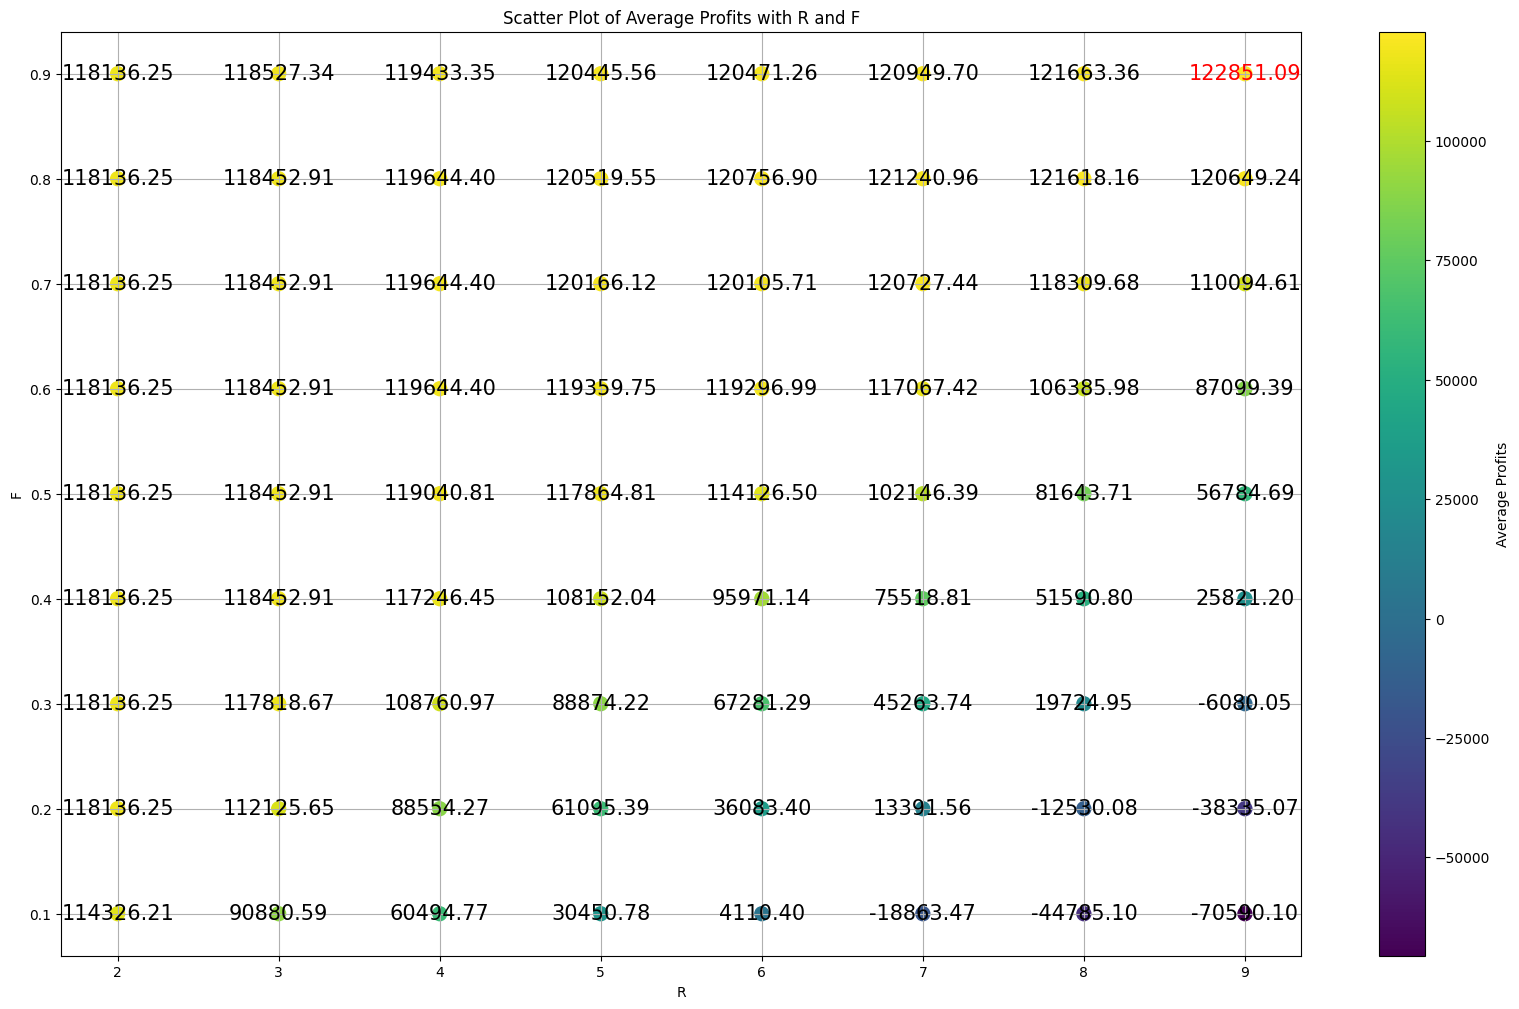

In [87]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_high_50_202411060137.png


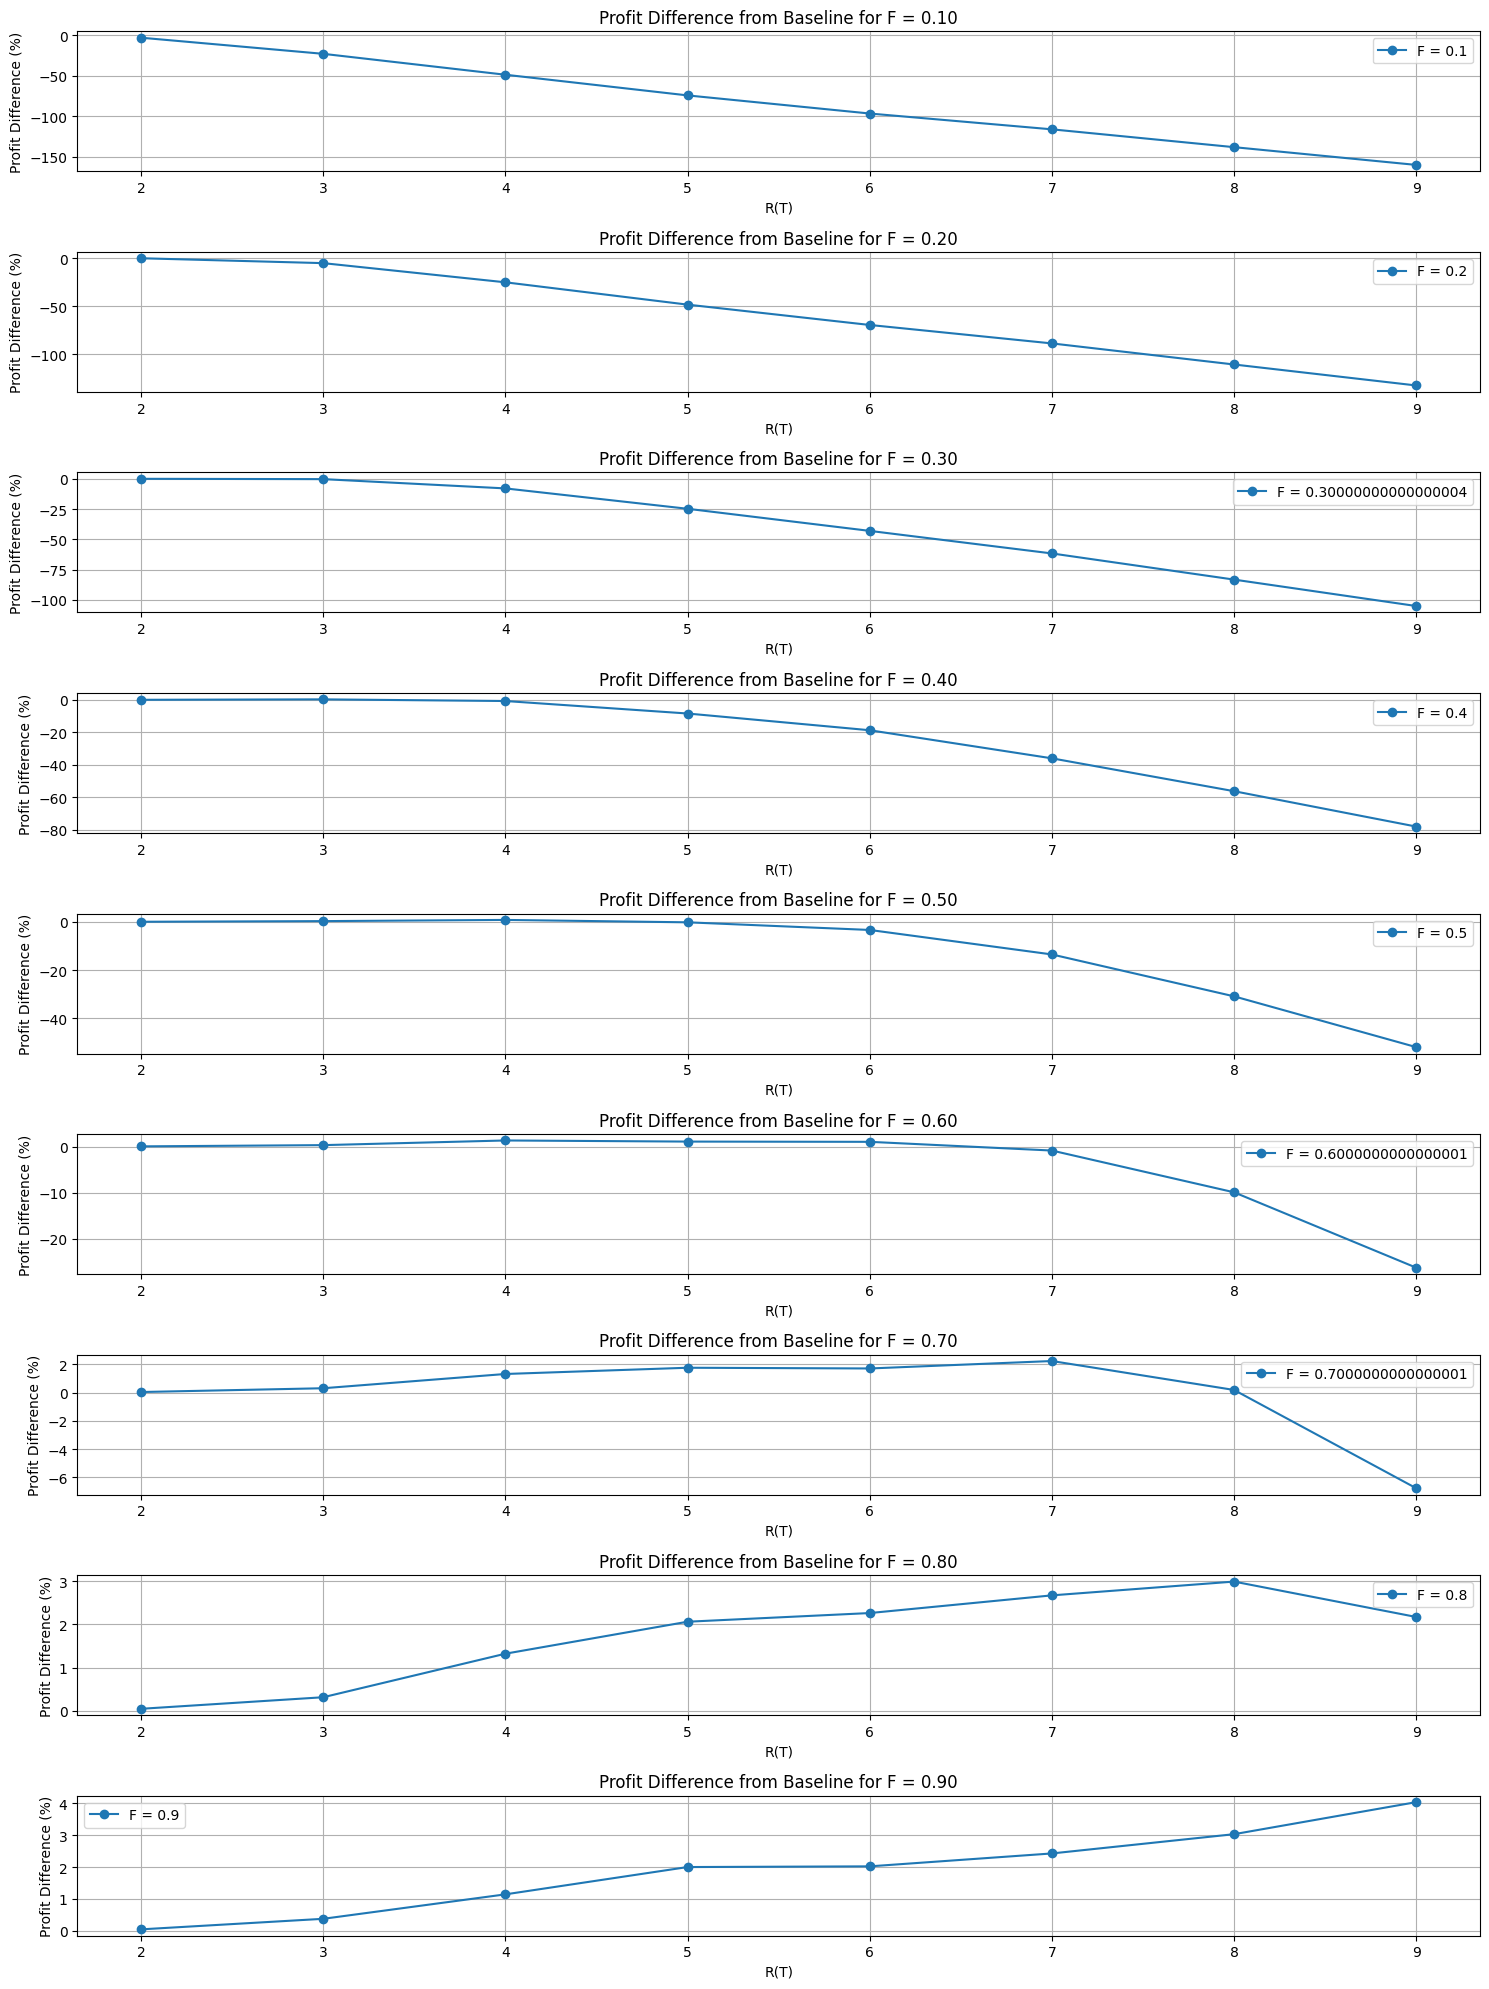

In [88]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(assigned_Fs):
    plt.subplot(len(assigned_Fs), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### (2)Grid for Fixed Rk & Flexible F


In [89]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=assigned_Ts,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)
results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is T=2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1040 rows, 1043 columns and 3400 nonzeros
Model fingerprint: 0x7d436ab9
Model has 40 general constraints
Variable types: 723 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 876 rows and 633 columns
Presolve time: 0.00s
Presolved: 164 rows, 410 columns, 1022 nonzeros
Presolved model has 40 SOS constraint(s)
Variable types: 

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    4884765.8735 4884765.87 -0.00%     -    0s

Explored 1 nodes (65 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 4.88477e+06 

Optimal solution found (tolerance 3.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 4.884765873477e+06, best bound 4.884765873477e+06, gap 0.0000%

model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 179.19459703545866
Alphas values:
alpha[0]: 0.0
alpha[1]: 0.0
alpha[2]: 2.163594282623379
----------------------------------------------
第 1 筆觀察資料:
第 2 天補貨策略: R_vars = 0.0
第 3 天補貨策略: R_vars = 1.0
第 4 天補貨策略:

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



  第 1 階段: 本階段期初庫存 = 142.22058293825313, 第一階段總需求 = 70.48390930939345, 銷售量 = 70.48390930939345, 本階段期末剩餘庫存 = 71.73667362885968, 本期損失 = 0.0
  第 2 階段: 本階段期初庫存 = 110.75256609465978, 重新預估需求 = 181.23647540405324, 第二階段總需求 = 72.51851131357027, 銷售量 = 72.51851131357027, 本階段期末剩餘庫存 = 38.23405478108951, 本期損失 = 0.0
  本觀察資料總利潤 = 106755.12554215308

----------------------------------------------
第 18 筆觀察資料:
第 2 天補貨策略: R_vars = 0.0
第 3 天補貨策略: R_vars = 0.0
第 4 天補貨策略: R_vars = 1.0
第 5 天補貨策略: R_vars = 0.0
第 6 天補貨策略: R_vars = 0.0
第 7 天補貨策略: R_vars = 0.0
第 8 天補貨策略: R_vars = 0.0
第 9 天補貨策略: R_vars = 0.0
*** 於第[4]天進貨 ***

第一階段需求量: 36.54504414896294
第二階段需求量: 139.2442462904684

Q0_optimal（最佳總庫存量）: 179.19459703545866
F_var（重新訂貨量佔總訂貨量比例）: 0.7440985877779421
Q0_var（期初庫存量）: 133.3384465915222

Q1_var（二次訂貨量）: 39.01592375621824
  Condition  Average_Error_Percentage  Max_Error_Percentage  \
0   Sold_1s                     6.293                24.162   
1   Left_0s                     5.990                35.211   
2   Le

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 179.19459703545866
Alphas values:
alpha[0]: 0.0
alpha[1]: 0.0
alpha[2]: 2.2670396172147385
----------------------------------------------
第 1 筆觀察資料:
第 2 天補貨策略: R_vars = 0.0
第 3 天補貨策略: R_vars = 0.0
第 4 天補貨策略: R_vars = 0.0
第 5 天補貨策略: R_vars = 1.0
第 6 天補貨策略: R_vars = 0.0
第 7 天補貨策略: R_vars = 0.0
第 8 天補貨策略: R_vars = 0.0
第 9 天補貨策略: R_vars = 0.0
*** 於第[5]天進貨 ***

第一階段需求量: 40.56354024055812
第二階段需求量: 117.58187835600435

Q0_optimal（最佳總庫存量）: 179.19459703545866
F_var（重新訂貨量佔總訂貨量比例）: 0.6330607006963996
Q0_var（期初庫存量）: 113.44105716027644

Q1_var（二次訂貨量）: 39.01592375621824
  Condition  Average_Error_Percentage  Max_Error_Percentage  \
0   Sold_1s                     6.362                24.670   
1   Left_0s                     4.695                38.546   
2   Left_1s                     0.000                 0.000   
3   Lost_1s                   100.000               1

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 179.19459703545866
Alphas values:
alpha[0]: 0.0
alpha[1]: 0.0
alpha[2]: 2.523968181951627
----------------------------------------------
第 1 筆觀察資料:
第 2 天補貨策略: R_vars = 0.0
第 3 天補貨策略: R_vars = 0.0
第 4 天補貨策略: R_vars = 0.0
第 5 天補貨策略: R_vars = 0.0
第 6 天補貨策略: R_vars = 1.0
第 7 天補貨策略: R_vars = 0.0
第 8 天補貨策略: R_vars = 0.0
第 9 天補貨策略: R_vars = 0.0
*** 於第[6]天進貨 ***

第一階段需求量: 73.51560092672858
第二階段需求量: 84.62981766983387

Q0_optimal（最佳總庫存量）: 179.19459703545866
F_var（重新訂貨量佔總訂貨量比例）: 0.7267756410565316
Q0_var（期初庫存量）: 130.23426813431232

Q1_var（二次訂貨量）: 39.01584808070288
  Condition  Average_Error_Percentage  Max_Error_Percentage  \
0   Sold_1s                     9.372                26.948   
1   Left_0s                     6.912                65.017   
2   Left_1s                     0.000                 0.000   
3   Lost_1s                   100.000               100

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



  第 1 階段: 本階段期初庫存 = 97.45757181478537, 第一階段總需求 = 83.2476467079887, 銷售量 = 83.2476467079887, 本階段期末剩餘庫存 = 14.209925106796668, 本期損失 = 0.0
  第 2 階段: 本階段期初庫存 = 53.225649683830724, 重新預估需求 = 136.47329639181942, 第二階段總需求 = 29.744688423382524, 銷售量 = 29.744688423382524, 本階段期末剩餘庫存 = 23.4809612604482, 本期損失 = 0.0
  本觀察資料總利潤 = 85697.67585300734

----------------------------------------------
第 30 筆觀察資料:
第 2 天補貨策略: R_vars = 0.0
第 3 天補貨策略: R_vars = 0.0
第 4 天補貨策略: R_vars = 0.0
第 5 天補貨策略: R_vars = 0.0
第 6 天補貨策略: R_vars = 0.0
第 7 天補貨策略: R_vars = 1.0
第 8 天補貨策略: R_vars = 0.0
第 9 天補貨策略: R_vars = 0.0
*** 於第[7]天進貨 ***

第一階段需求量: 117.53420549542926
第二階段需求量: 80.97802465641759

Q0_optimal（最佳總庫存量）: 179.19459703545866
F_var（重新訂貨量佔總訂貨量比例）: 0.9316762903392377
Q0_var（期初庫存量）: 166.95135741483068

Q1_var（二次訂貨量）: 39.01592375621931
  Condition  Average_Error_Percentage  Max_Error_Percentage  \
0   Sold_1s                     9.478                21.263   
1   Left_0s                     8.558                50.126   
2   Le

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/646569299.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


  Matrix range     [1e+00, 8e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 759 rows and 535 columns
Presolve time: 0.00s
Presolved: 281 rows, 508 columns, 1369 nonzeros
Presolved model has 40 SOS constraint(s)
Variable types: 508 continuous, 0 integer (0 binary)

Root relaxation: objective 5.010509e+06, 139 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5010509.37    0   26          - 5010509.37      -     -    0s
     0     0 5002797.56    0   21          - 5002797.56      -     -    0s
     0     0 5002797.56    0   21          - 5002797.56      -     -    0s
H    0     0                    4269419.2063 5002797.56  17.2%     -    0s

Explored 1 nodes (181 simplex iterations) in 0.10 seconds (0.01 work units)
Thread count was 12 (of 12 available proc

R(T)                                                  R  average_profits  \
6     8  [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...    124185.892466   
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...    123862.602891   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...    123017.246622   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...    122755.372771   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...    122411.533625   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...    122119.146837   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    121671.508144   
7     9  [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...    106735.480158   

   average_losses  average_lefts  average_operation_profits  \
6        0.000000      29.655982              126303.230242   
5        0.000000      46.147339              126303.230249   
4        0.000000      67.667373              126303.230249   
3        0.000000      85.157467              126303.230248   
2        0.000000     105.873351              126303.230249   
1        0.000000     126.202614              126303.230249   
0        0.000000     148.321047              126303.230249   
7        6.158618      90.709854              121376.336022   

                      alpha_values  \
6  [0.04180894787334406, 0.0, 0.0]   
5    [0.0, 0.0, 2.612728580071593]   
4    [0.0, 0.0, 2.523968181951627]   
3   [0.0, 0.0, 2.2670396172147385]   
2    [0.0, 0.0, 2.193442353850054]   
1    [0.0, 0.0, 2.163594282623379]   
0    [0.0, 0.0, 1.791955882971951]   
7    [0.0, 0.0, 2.613677747966871]   

                                              F_vars  \
6  [0.6954241651642903, 0.8070050109210989, 0.871...   
5  [0.6781630482624034, 0.8235282785312658, 0.859...   
4  [0.7267756410565316, 0.7592269654077588, 0.925...   
3  [0.6330607006963996, 0.7374480417668857, 0.897...   
2  [0.6612916350034118, 0.7760235183620255, 0.867...   
1  [0.6336118945938242, 0.7584072641589766, 0.896...   
0  [0.7967864808350283, 0.8146632002101769, 0.857...   
7  [0.6766851666826913, 0.7968222692569185, 0.853...   

                                             Q0_vars  \
6  [124.61625304533524, 144.61093773760223, 156.1...   
5  [121.52315415771967, 147.57181801871513, 153.9...   
4  [130.23426813431232, 136.04937012469745, 165.8...   
3  [113.44105716027644, 132.14670467900518, 160.7...   
2  [118.49988805735599, 139.05922166292203, 155.3...   
1  [113.53982812861383, 135.90248408973247, 160.7...   
0  [142.77983235653411, 145.98324388127983, 153.5...   
7  [121.25832576357705, 142.78624544837325, 152.9...   

                                             Q1_vars  
6  [39.01577374322591, 39.01584722001749, 39.0158...  
5  [39.01581606094025, 39.01588984725754, 39.0159...  
4  [39.01584808070288, 39.015864408776444, 39.015...  
3  [39.01592375621824, 39.01592375621824, 39.0159...  
2  [39.01592375621824, 39.01592375621931, 39.0159...  
1  [39.015817667508976, 39.01587961425176, 39.015...  
0  [39.01590825708732, 39.01591341564014, 39.0159...  
7  [39.01592375621824, 39.01592375621824, 39.0159...

In [90]:
if results_df_2 is not None:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/high_s2_50_202411060137.pkl


In [91]:
stimulation_results_df_2

R         F        profits  losses      lefts  operation_profits
0   6  0.695424  125419.013239     0.0  10.226761      126516.334877
1   6  0.807005  137907.539764     0.0  19.168699      139706.317405
2   6  0.871163  158066.428343     0.0   8.880147      158066.428058
3   6  0.700686  128241.086044     0.0  26.729074      128924.858727
4   6  0.500002   79849.864242     0.0  28.802320       83454.006918
5   6  0.721465  124249.608774     0.0  29.126322      126327.426397
6   6  0.692215  126173.082411     0.0  28.569557      127027.578041
7   6  0.885871  159869.977326     0.0  27.445124      159869.977326
8   6  0.771235  144455.861052     0.0  18.536653      144455.861052
9   6  0.696732  103003.074954     0.0  38.267414      108621.084238
10  6  0.500002   83166.319257     0.0  32.614716       84375.633418
11  6  0.501548   85231.640731     0.0  21.389712       88807.765189
12  6  0.686264  105239.006369     0.0  42.695997      110109.684859
13  6  0.632127  113637.677699     0.0  15.480887      115276.451988
14  6  0.731814   99555.681536     0.0  41.362404      100626.488067
15  6  0.619264  109604.763963     0.0  23.124251      111681.330809
16  6  0.653938  111762.826523     0.0  18.007053      114401.936498
17  6  0.833651  138108.984743     0.0  37.339058      140631.432352
18  6  0.705769  141995.272064     0.0  38.960069      141995.272064
19  6  0.814130  137931.012347     0.0  28.054904      139929.376968
20  6  0.840176  148377.489437     0.0  15.219133      149033.323914
21  6  0.889911  145118.364720     0.0  40.072839      147851.986086
22  6  0.704560  102873.394838     0.0  46.486029      108741.764532
23  6  0.626029  108109.027237     0.0  20.075928      110678.686441
24  6  0.700626  128965.274396     0.0  14.451344      129502.496100
25  6  0.606899  123447.997990     0.0  18.826129      123447.997990
26  6  0.717493  106969.183988     0.0  47.402292      112389.210974
27  6  0.771606  149061.274607     0.0  35.461660      149061.274607
28  6  0.573398   84639.237596     0.0  34.655043       90393.868105
29  6  0.971198  155902.362468     0.0  44.971628      158809.784121
30  6  0.703789  122103.129067     0.0  17.010992      124103.466386
31  6  0.670494  115133.884793     0.0  25.159580      117573.455761
32  6  0.858963  130276.179584     0.0  56.534093      135090.931245
33  6  0.900068  137259.532515     0.0  63.880126      141856.129820
34  6  0.573681  121057.788307     0.0  28.119188      121057.788307
35  6  0.899234  147472.416473     0.0  42.708029      150002.540124
36  6  0.755444  131820.998802     0.0  22.826576      133358.763709
37  6  0.699972  135629.606421     0.0  20.291998      135629.606421
38  6  0.708486  117822.794961     0.0  30.377561      120813.850714
39  6  0.767380  141927.039076     0.0  26.927973      141927.039076

In [92]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

R(T)  average_profits
6     8    124185.892466
5     7    123862.602891
4     6    123017.246622

### (4)Grid for Fixed F & Flexible Rk


In [93]:
assigned_Fs = np.arange(0.1, 1.0, 0.1)

results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = grid_fixed_F_flexible_R(
    assigned_Fs=assigned_Fs,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)


results_df_4

+++++++++++++++++++++++++++++++++++++++ THis is F=0.1 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2288 columns and 5960 nonzeros
Model fingerprint: 0xb5380846
Model has 280 quadratic constraints
Model has 640 general constraints
Variable types: 1968 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 800 rows 

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/1890344136.py:238: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2288 columns and 5960 nonzeros
Model fingerprint: 0x52fa3f75
Model has 280 quadratic constraints
Model has 640 general constraints
Variable types: 1968 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [2e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 800 rows and 601 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible or unbounde

R(T)  average_losses  \
0  [9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, ...        0.020641   

   average_lefts  average_operation_profits  average_profits  \
0      51.067668              126286.717272    123499.919823   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                              F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...   

                                             Q0_vars  \
0  [161.2751373319128, 161.2751373319128, 161.275...   

                                             Q1_vars  
0  [0.0, 20.526986466658116, 30.669598402115923, ...

In [94]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4", beta_values=results_df_4.iloc[0]["beta_values"]
    )

Model parameters saved as models/high_s4_50_202411060137.pkl


In [95]:
stimulation_results_df_4

R(T)    F        profits    losses       lefts  operation_profits
0      9  0.9  125890.391130  0.000000   31.580135      126516.334877
1      9  0.9  138272.471996  0.000000   12.228942      139706.317405
2      9  0.9  156745.390188  0.825649    4.812651      157405.909266
3      9  0.9  128258.170160  0.000000   36.041814      128924.858727
4      9  0.9   72062.481181  0.000000  139.416759       83454.006918
5      9  0.9  124320.992952  0.000000   40.255235      126327.426397
6      9  0.9  125487.547272  0.000000   51.324801      127027.578041
7      8  0.9  159869.977326  0.000000   29.977036      159869.977326
8      9  0.9  143159.625211  0.000000   17.464545      144455.861052
9      9  0.9  103521.327831  0.000000   59.780482      108621.084238
10     9  0.9   73214.514307  0.000000  145.641754       84375.633418
11     9  0.9   78754.679020  0.000000  109.572340       88807.765189
12     9  0.9  105382.078608  0.000000   79.649830      110109.684859
13     9  0.9  111840.537519  0.000000   55.546587      115276.451988
14     9  0.9   93528.082617  0.000000   92.583542      100626.488067
15     9  0.9  107346.636045  0.000000   61.428403      111681.330809
16     9  0.9  110747.393157  0.000000   46.234685      114401.936498
17     9  0.9  139368.964733  0.000000   23.807146      140631.432352
18     9  0.9  141995.272064  0.000000   43.671163      141995.272064
19     9  0.9  139929.376968  0.000000   19.096362      139929.376968
20     9  0.9  148400.359392  0.000000   16.397369      149033.323914
21     9  0.9  145332.997069  0.000000   21.162114      147851.986086
22     9  0.9  103672.178199  0.000000   72.146306      108741.764532
23     9  0.9  106093.330585  0.000000   69.071607      110678.686441
24     9  0.9  128399.675003  0.000000   41.841234      129502.496100
25     9  0.9  122054.970021  0.000000   54.690317      123447.997990
26     9  0.9  108231.486251  0.000000   67.777355      112389.210974
27     9  0.9  148157.163965  0.000000   48.869349      149061.274607
28     9  0.9   80737.307665  0.000000  102.672650       90393.868105
29     6  0.9  158809.784121  0.000000   73.033160      158809.784121
30     9  0.9  122874.305517  0.000000   28.519466      124103.466386
31     9  0.9  114711.792235  0.000000   45.511480      117573.455761
32     9  0.9  133760.768441  0.000000   36.493627      135090.931245
33     9  0.9  141106.958347  0.000000   32.960357      141856.129820
34     9  0.9  119067.207917  0.000000   65.192750      121057.788307
35     9  0.9  149481.414186  0.000000   26.375577      150002.540124
36     9  0.9  133264.468389  0.000000   27.808218      133358.763709
37     9  0.9  135455.390336  0.000000   37.647842      135629.606421
38     9  0.9  118762.285926  0.000000   41.716095      120813.850714
39     9  0.9  141927.039076  0.000000   32.705632      141927.039076

Plot saved as plots/result_4_metrics_train_high_50_202411060137.png


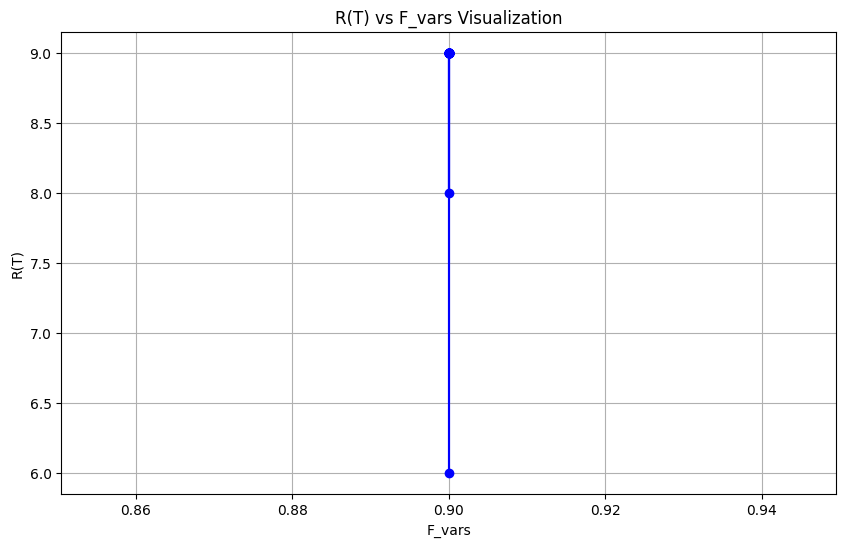

In [96]:
if results_df_4 is not None:

    r_values = results_df_4["R(T)"].explode().values
    f_values = results_df_4["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_4_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_4 is None")

### (3)Fully flexible F & Rk


#### (5)Simple beta with softmax


In [97]:
results_df_5, stimulation_results_df_5 = None, None
results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_5

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2395 columns and 5600 nonzeros
Model fingerprint: 0x777e68b4
Model has 320 quadratic constraints
Model has 720 general constraints
Variable types: 2075 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/1898876225.py:242: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Presolve added 453 rows and 49798 columns
Presolve time: 0.58s
Presolved: 14573 rows, 55073 columns, 190257 nonzeros
Presolved model has 360 SOS constraint(s)
Presolved model has 2880 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 54433 continuous, 640 integer (640 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 5.026414e+06, 1620 iterations, 0.29 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5026413.63    0 2290          - 5026413.63      -     -    2s
     0     0 5026413.63    0 2283          - 5026413.63      -     -    2s
     0     0 5026413.63    0 2283          - 5026413.63      -     -    2s
H    0     0                    4910938.9152 5026413.63  2.35%     -    3s

Explored 1 nodes (1

average_profits  average_losses  average_lefts  average_operation_profits  \
0     122773.47288             0.0      84.641897              126303.230249   

                    alpha_values  \
0  [0.0, 4.968388551709722, 0.0]   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [98]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
    )

Model parameters saved as models/high_s5_50_202411060137.pkl


In [99]:
stimulation_results_df_5

R(T)  R         F   f_values     Q0_vars    Q1_vars        profits  \
0      4  2  0.999952   9.936777  179.185931   0.000000  122308.232381   
1      4  2  0.993307  14.905166  177.995286   0.079859  139017.867672   
2      4  2  0.880797   4.968389  157.834141  39.015924  158066.428343   
3      7  5  0.699217   4.968389  125.295995  39.015726  128293.729217   
4      9  7  0.997527  14.905166  178.751520   0.000000   68567.204593   
5      9  7  0.937202   4.968389  167.941450   0.000000  124320.992952   
6      7  5  0.668203   4.968389  119.738345  39.015924  127027.578041   
7      4  2  0.729814   4.968389  130.778753  39.015924  159869.977326   
8      3  1  0.880797   4.968389  157.834141  32.490653  142504.867596   
9      9  7  0.880797   4.968389  157.834141   0.000000  104209.527125   
10     8  6  0.982014   4.968389  175.971569   0.000000   70275.228071   
11     9  7  0.997527  14.905166  178.751520   0.000000   75259.402432   
12     9  7  0.880797   4.968389  157.834141   0.000000  106070.277901   
13     9  7  0.997527  14.905166  178.751520   0.000000  108345.260931   
14     9  7  0.982014   9.936777  175.971585   0.000000   90588.793179   
15     9  7  0.982014   9.936777  175.971585   0.000000  104407.346607   
16     9  7  0.982014   9.936777  175.971585   0.000000  107808.103718   
17     5  3  0.750513   4.968389  134.487818  39.015924  140631.432352   
18     8  6  0.705770   9.936777  126.470237  39.015924  141995.272064   
19     9  7  0.952574   9.936777  170.696196   0.496431  139929.376968   
20     3  1  0.753581   9.936777  135.037630  39.015924  149033.323914   
21     6  4  0.880797   4.968389  157.834141  26.980842  147851.986086   
22     9  7  0.880798   9.936777  157.834247   0.000000  104360.356267   
23     8  6  0.997527  14.905166  178.751520   0.000000  102598.053997   
24     8  6  0.700627   4.968389  125.548502  39.015726  128965.274396   
25     8  6  0.606901   9.936777  108.753297  39.015924  123447.997990   
26     9  7  0.997527  14.905166  178.751520   0.000000  104736.209664   
27     8  6  0.880797   4.968389  157.834141  28.492452  149061.274607   
28     9  7  0.997527  14.905166  178.751520   0.000000   77242.031077   
29     4  2  0.880797   4.968389  157.834141  39.015924  158809.784121   
30     9  7  0.892030   9.936777  159.846995   0.000000  123159.933903   
31     9  7  0.997527  14.905166  178.751520   0.000000  111216.515647   
32     9  7  0.993307  14.905166  177.995286   0.000000  133264.606818   
33     2  0  0.727996   9.936777  130.452885  39.015924  141856.129820   
34     7  5  0.562836   4.968389  100.857096  39.015924  121057.788307   
35     4  2  0.808971   9.936777  144.963242  39.015924  150002.540124   
36     4  2  0.701280   9.936777  125.665612  39.015924  133358.763709   
37     7  5  0.982014   4.968389  175.971569   0.000000  134342.694324   
38     9  7  0.997527  14.905166  178.751520   0.000000  115267.009338   
39     8  6  0.993307  14.905166  177.995286   0.000000  141809.741607   

    losses       lefts  operation_profits  
0      0.0  174.457596      126516.334877  
1      0.0  123.310930      139706.317405  
2      0.0   52.365617      158066.428343  
3      0.0   38.955187      128924.858727  
4      0.0  174.369525       83454.006918  
5      0.0   46.921548      126327.426397  
6      0.0   27.497961      127027.578041  
7      0.0  115.365304      159869.977326  
8      0.0  115.590815      144455.861052  
9      0.0   52.898489      108621.084238  
10     0.0  183.444113       84375.633418  
11     0.0  144.525106       88807.765189  
12     0.0   72.767837      110109.684859  
13     0.0   90.499353      115276.451988  
14     0.0  121.976437      100626.488067  
15     0.0   90.821297      111681.330809  
16     0.0   75.627579      114401.936498  
17     0.0   81.715528      140631.432352  
18     0.0   38.959922      141995.272064  
19     0.0   28.517420      139929.376968  
20     0.0  108.269460      149033.323914  
2

#### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [100]:
results_df_6, stimulation_results_df_6 = None, None
results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_6

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2331 columns and 6080 nonzeros
Model fingerprint: 0x908e72b6
Model has 280 quadratic constraints
Model has 680 general constraints
Variable types: 2011 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/3644731949.py:254: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Presolve added 413 rows and 43621 columns
Presolve time: 0.61s
Presolved: 3493 rows, 45952 columns, 140417 nonzeros
Presolved model has 320 SOS constraint(s)
Presolved model has 280 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 45312 continuous, 640 integer (640 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 5.026414e+06, 1650 iterations, 0.41 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5026413.63    0  413          - 5026413.63      -     -    1s
     0     0 5026413.63    0  411          - 5026413.63      -     -    1s
     0     0 5026413.63    0  411          - 5026413.63      -     -    1s
     0     0 5026413.63    0  453          - 5026413.63      -     -    2s
     0     0 5026413.6

average_profits  average_losses  average_lefts  average_operation_profits  \
0    123374.896893             0.0       77.05354              126303.230249   

                    alpha_values  \
0  [0.0, 0.0, 9.936777103419457]   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [101]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
    )

Model parameters saved as models/high_s6_50_202411060137.pkl


In [102]:
stimulation_results_df_6

R(T)  R         F  f_values     Q0_vars    Q1_vars        profits  losses  \
0      5  3  0.999952  9.936777  179.185931   0.000000  122308.232381     0.0   
1      5  3  0.999952  9.936777  179.185931   0.000000  138795.710540     0.0   
2      9  7  0.999952  9.936777  179.185931  18.397104  158066.428343     0.0   
3      7  5  0.699219  9.936777  125.296235  39.015486  128293.729217     0.0   
4      9  7  0.500005  9.936777   89.598189  16.693413   83059.188293     0.0   
5      9  7  0.937202  9.936777  167.941450   0.000000  124320.992952     0.0   
6      7  5  0.668204  9.936777  119.738584  39.015924  127027.578041     0.0   
7      4  2  0.729815  9.936777  130.778992  39.015924  159869.977326     0.0   
8      6  4  0.689739  9.936777  123.597546  39.015924  144455.861052     0.0   
9      9  7  0.982014  9.936777  175.971585   0.000000  100582.038393     0.0   
10     9  7  0.500005  9.936777   89.598189  15.871353   84375.633418     0.0   
11     9  7  0.982014  9.936777  175.971585   0.000000   75815.389582     0.0   
12     9  7  0.982014  9.936777  175.971585   0.000000  102442.789169     0.0   
13     9  7  0.982014  9.936777  175.971585   0.000000  108901.248080     0.0   
14     9  7  0.982014  9.936777  175.971585   0.000000   90588.793179     0.0   
15     9  7  0.982014  9.936777  175.971585   0.000000  104407.346607     0.0   
16     9  7  0.982014  9.936777  175.971585   0.000000  107808.103718     0.0   
17     6  4  0.748779  9.936777  134.177184  39.015924  140631.432352     0.0   
18     9  7  0.982014  9.936777  175.971585   1.522506  141995.272064     0.0   
19     9  7  0.952574  9.936777  170.696196   0.496431  139929.376968     0.0   
20     3  1  0.753581  9.936777  135.037630  39.015924  149033.323914     0.0   
21     3  1  0.743042  9.936777  133.149038  39.015924  147851.986086     0.0   
22     9  7  0.982014  9.936777  175.971585   0.000000  100732.888761     0.0   
23     9  7  0.982014  9.936777  175.971585   0.000000  103154.041147     0.0   
24     8  6  0.700628  9.936777  125.548742  39.015487  128965.274396     0.0   
25     8  6  0.606901  9.936777  108.753297  39.015924  123447.997990     0.0   
26     9  7  0.982014  9.936777  175.971585   0.000000  105292.196813     0.0   
27     3  1  0.999952  9.936777  179.185931   7.140662  149061.274607     0.0   
28     9  7  0.982014  9.936777  175.971585   0.000000   77798.018227     0.0   
29     2  0  0.999952  9.936777  179.185931  19.326299  158809.784121     0.0   
30     8  6  0.703791  9.936777  126.115532  39.015487  122103.129067     0.0   
31     9  7  0.982014  9.936777  175.971585   0.000000  111772.502797     0.0   
32     9  7  0.761735  9.936777  136.498741  39.015737  133760.768441     0.0   
33     2  0  0.727996  9.936777  130.452885  39.015924  141856.129820     0.0   
34     8  6  0.573683  9.936777  102.800835  39.015924  121057.788307     0.0   
35     2  0  0.772280  9.936777  138.388491  39.015924  150002.540124     0.0   
36     3  1  0.699260  9.936777  125.303671  39.015924  133358.763709     0.0   
37     8  6  0.699974  9.936777  125.431547  39.015924  135629.606421     0.0   
38     9  7  0.982014  9.936777  175.971585   0.000000  115822.996487     0.0   
39     9  7  0.993307  9.936777  177.995280   0.000000  141809.742798     0.0   

         lefts  operation_profits  
0   159.662903      126516.334877  
1   109.841686      139706.317405  
2    17.085145      158066.428343  
3    38.955426      128924.858727  
4    12.756275       83454.006918  
5    46.921548      126327.426397  
6    27.497961      127027.578041  
7   115.365304      159869.977326  
8    45.575454      144455.861052  
9    89.173376      108621.084238  
10   18.159210       84375.633418  
11  138.965235       88807.765189  
12  109.042724      110109.684859  
13   84.939481      115276.451988  
14  121.976437      100626.488067  
15   90.821297      111681.330809  
16   75.627579      114401.936498  
17   64.280466      140631.432352 

#### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [ ]:
results_df_3, stimulation_results_df_3 = None, None
results_df_3, stimulation_results_df_3 = fully_flexible_simple_beta_with_softmax_3(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_3

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_59258/2081417320.py:254: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2331 columns and 6360 nonzeros
Model fingerprint: 0x39fd69dc
Model has 280 quadratic constraints
Model has 680 general constraints
Variable types: 2011 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 693 rows and 43901 columns
Presolve time: 0.51s
Presolved: 3773 rows, 46232 columns, 141257 nonzeros
Presolved model has 320 SOS constraint(s)
Presolved model has 280 bilinear constraint(s)

Solving non-convex MIQCP

Vari

In [ ]:
if results_df_3 is not None:
    save_model_parameters(
        f"{model_prefix}_s3",
        alpha_values=results_df_3.iloc[0]["alpha_values"],
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
    )

Model parameters saved as models/low_s3_50_202411060125.pkl


In [ ]:
stimulation_results_df_3

R(T)  R         F  f_values     Q0_vars    Q1_vars       profits  \
0      7  5  0.822934  1.613569  112.382664  39.015924  31629.083719   
1      4  2  0.822934  1.613569  112.382664  39.015924  34926.579351   
2      2  0  0.822934  1.613569  112.382664  39.015924  39516.607086   
3      6  4  0.822934  1.613569  112.382664  28.106682  32231.214682   
4      9  7  0.822934  1.613569  112.382664   0.000000  14411.377704   
5      2  0  0.822934  1.613569  112.382664  39.015924  31581.856599   
6      8  6  0.822934  1.613569  112.382664  39.015924  31756.894510   
7      4  2  0.822934  1.613569  112.382664  39.015924  39967.494331   
8      7  5  0.822934  1.613569  112.382664  39.015924  36113.965263   
9      5  3  0.822934  1.613569  112.382664  16.349300  27155.271060   
10     9  7  0.822934  1.613569  112.382664   0.000000  15563.410830   
11     8  6  0.822934  1.613569  112.382664   0.000000  21103.575543   
12     9  7  0.822934  1.613569  112.382664  25.254442  27527.421215   
13     6  4  0.822934  1.613569  112.382664  16.947648  28819.112997   
14     9  7  0.822934  1.613569  112.382664  13.400446  25156.622017   
15     5  3  0.822934  1.613569  112.382664  19.406555  27920.332702   
16     6  4  0.822934  1.613569  112.382664  30.619757  28600.484125   
17     4  2  0.822934  1.613569  112.382664  39.015924  35157.858088   
18     2  0  0.822934  1.613569  112.382664  39.015924  35498.818016   
19     2  0  0.822934  1.613569  112.382664  39.015924  34982.344242   
20     5  3  0.822934  1.613569  112.382664  39.015924  37258.330979   
21     4  2  0.822934  1.613569  112.382664  39.015924  36962.996521   
22     2  0  0.822934  1.613569  112.382664  24.817714  26166.903235   
23     8  6  0.822934  1.613569  112.382664  20.306289  27669.671610   
24     5  3  0.822934  1.613569  112.382664  39.015924  32375.624025   
25     9  7  0.822934  1.613569  112.382664  36.922196  30395.080883   
26     2  0  0.822934  1.613569  112.382664  28.103850  28097.302744   
27     2  0  0.822934  1.613569  112.382664  39.015924  37265.318652   
28     6  4  0.822934  1.613569  112.382664   1.636579  21776.941095   
29     3  1  0.822934  1.613569  112.382664  39.015924  39702.446030   
30     2  0  0.822934  1.613569  112.382664  27.413788  31025.866597   
31     5  3  0.822934  1.613569  112.382664  17.710995  29393.363940   
32     2  0  0.822934  1.613569  112.382664  39.015924  33772.732811   
33     6  4  0.822934  1.613569  112.382664  39.015924  35464.032455   
34     9  7  0.822934  1.613569  112.382664  38.939572  30264.447077   
35     3  1  0.822934  1.613569  112.382664  39.015924  37500.635031   
36     4  2  0.822934  1.613569  112.382664  39.015924  33339.690927   
37     6  4  0.822934  1.613569  112.382664  39.015924  33907.401605   
38     4  2  0.822934  1.613569  112.382664  27.436292  30203.462678   
39     2  0  0.822934  1.613569  112.382664  39.015924  35481.759769   

      losses       lefts  operation_profits  
0   0.000000   28.033079       31629.083719  
1   0.000000   77.490368       34926.579351  
2   0.000000  119.551188       39516.607086  
3   0.000000   58.467846       32231.214682  
4   0.000000   41.631812       20863.501729  
5   0.000000  102.023353       31581.856599  
6   0.000000   20.024450       31756.894510  
7   0.000000  115.365304       39967.494331  
8   0.000000   30.622982       36113.965263  
9   0.000000   49.063360       27155.271060  
10  0.000000   47.856807       21093.908355  
11  0.000000   27.389987       22201.941297  
12  0.000000    7.119325       27527.421215  
13  0.000000   39.942689       28819.112997  
14  0.000000    8.199042       25156.622017  
15  0.000000   58.383007       27920.332702  
16  0.000000   23.240662       28600.484125  
17  0.000000  100.228323       35157.858088  
18  0.000000  132.754944       35498.818016  
19  0.000000  113.668161       34982.344242  
20  0.000000   60.602020       37258.330979  
21  0.000000  104.856006       36962.99

#### (7)Beta with softmax


In [ ]:
results_df_7, stimulation_results_df_7 = None, None
results_df_7, stimulation_results_df_7 = fully_flexible_beta_with_softmax_7(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_7

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 1960 rows, 2387 columns and 6240 nonzeros
Model fingerprint: 0x8873cf8d
Model has 320 quadratic constraints
Model has 720 general constraints
Variable types: 2067 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_58219/3059651940.py:247: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Presolve added 811 rows and 50174 columns
Presolve time: 0.20s
Presolved: 10011 rows, 54201 columns, 176893 nonzeros
Presolved model has 360 SOS constraint(s)
Presolved model has 1680 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 53581 continuous, 620 integer (620 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 1.261192e+06, 2081 iterations, 0.11 seconds (0.18 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1261192.24    0 1806          - 1261192.24      -     -    0s
     0     0 1261192.24    0 1780          - 1261192.24      -     -    0s
     0     0 1261192.24    0 1780          - 1261192.24      -     -    0s
     0     0 1261192.22    0 1805          - 1261192.22      -     -    0s
     0     0 1261192

In [ ]:
if results_df_7 is not None:
    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
    )

Model parameters saved as models/low_s7_10_202411060117.pkl


In [ ]:
results_df_7

average_profits  average_losses  average_lefts  average_operation_profits  \
0      29134.98719             0.0     133.599395               33046.050667   

                       alpha_values  \
0  [0.024338472395502377, 0.0, 0.0]   

                                         beta_values  \
0  [[0.0, 0.0894717835347194, -0.2684342573380149...   

                                          tau_values  
0  [[-1.8906733856738356e-05], [-1.89067338580748...

In [ ]:
stimulation_results_df_7

R(T)  R         F  f_values     Q0_vars    Q1_vars       profits  losses  \
0     2  0  0.880797  2.080651  121.539277  19.145591  30952.624097     0.0   
1     2  0  0.779033  2.121144  107.497077  40.456521  35117.397465     0.0   
2     2  0  0.887528  2.093781  122.468118  40.456521  39128.231192     0.0   
3     2  0  0.886517  2.079694  122.328594   8.952842  35364.026978     0.0   
4     2  0  0.884399  2.050189  122.036365  13.313925 -12040.576847     0.0   
5     2  0  0.888282  2.104279  122.572088  14.833298  32384.614480     0.0   
6     2  0  0.880797  2.053580  121.539274   5.428184  32023.928111     0.0   
7     2  0  0.880797  2.164122  121.539278  32.972150  40149.652043     0.0   

        lefts  operation_profits  
0  115.255458       30952.624097  
1  108.200830       35117.397465  
2  114.728114       39128.231192  
3  156.001568       35364.026978  
4  145.604915       19247.930974  
5  129.690836       32384.614480  
6  146.723569       32023.928111  
7  152.589870       40149.652043

## Analysis


### 單次進貨策略


In [ ]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 19309.526261875588


### 策略一


In [ ]:
# 策略一
results_df_1

R(T)    F          Q0  average_profits  average_losses  average_lefts  \
53     7  0.9  122.907131     25044.891663       11.331867       2.497711   
52     7  0.8  109.250783     24834.716065       12.506703       2.173013   
62     8  0.9  122.907131     24543.163803       10.794282       3.393664   
43     6  0.8  109.250783     22302.378035       17.548190       2.817692   
44     6  0.9  122.907131     22170.063904       16.910150       3.302105   
..   ...  ...         ...              ...             ...            ...   
55     8  0.2   27.312696    -62574.270813       84.627632      75.373782   
65     9  0.3   40.969044    -67732.896457       85.824408      81.223676   
54     8  0.1   13.656348    -78961.888244       98.283980      89.030130   
64     9  0.2   27.312696    -84120.513888       99.480755      94.880024   
63     9  0.1   13.656348   -100508.131318      113.137103     108.536372   

    average_operation_profits  baseline_profit  profit_diff_percent  
53               29309.434079     19309.526262            29.702258  
52               29074.466978     19309.526262            28.613803  
62               29416.951091     19309.526262            27.103915  
43               28066.169609     19309.526262            15.499354  
44               28193.777594     19309.526262            14.814126  
..                        ...              ...                  ...  
55               14650.281075     19309.526262          -424.059068  
65               14410.926047     19309.526262          -450.774512  
54               11919.011503     19309.526262          -508.927113  
64               11679.656475     19309.526262          -535.642557  
63                8948.386904     19309.526262          -620.510602  

[72 rows x 9 columns]

In [ ]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]
    avg_profit_for_s1 = results_df_1["average_profits"].mean()

    print(f"策略1平均利潤為：{avg_profit_for_s1}")
    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1平均利潤為：450.9894651736908
策略1最佳策略在：R=7.0, F=0.9
策略1最佳策略之下最大利潤為：25044.89166261529


### 策略二


In [ ]:
# 策略二
results_df_2

R(T)                                                  R  average_profits  \
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     29791.327700   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     29546.551839   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...     29454.895633   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     29040.835679   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...     27695.008214   

   average_losses  average_lefts  average_operation_profits  \
1        0.000000      88.822980               31575.807562   
2        0.000000      72.029532               31575.807562   
3        0.000000      54.988687               31575.807562   
0        0.000000     108.341262               31575.807562   
4        0.134056      69.968047               31548.996339   

                     alpha_values  \
1   [0.0, 0.0, 2.243662827656465]   
2    [0.0, 0.0, 2.45410500820561]   
3   [0.0, 0.0, 8.560741964485777]   
0  [0.0, 0.0, 1.5024918679850785]   
4           [0.0, 0.0, 1000000.0]   

                                              F_vars  \
1  [0.5585812916546653, 0.722334045334274, 0.9041...   
2  [0.6080824503605237, 0.7586304713071478, 0.878...   
3  [0.5911295823647191, 0.7281027081293117, 0.999...   
0  [0.7387164172420172, 0.7621737219493125, 0.817...   
4  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                             Q0_vars  \
1  [76.2818042623438, 98.64444993313776, 123.4673...   
2  [83.04185468933514, 103.60121612429253, 119.91...   
3  [80.72671206379084, 99.43223859122726, 136.537...   
0  [100.88168362837577, 104.08509475749449, 111.7...   
4  [136.56347858765005, 136.56347858765005, 136.5...   

                                             Q1_vars  
1  [39.01580269466406, 39.0158749317315, 39.01592...  
2  [39.01581591794688, 39.01588061111556, 39.0159...  
3  [39.01546633087594, 39.015642457390115, 39.015...  
0  [39.015907228931994, 39.015912783111816, 39.01...  
4  [2.5386868092880377, 8.35380512774671, 38.2037...

In [ ]:
stimulation_results_df_2

R         F       profits  losses       lefts  operation_profits
0   1  0.558581  31629.083719     0.0   97.501315       31629.083719
1   1  0.722334  34926.579351     0.0   94.490861       34926.579351
2   1  0.904103  39516.607086     0.0   90.714407       39516.607086
3   1  0.798956  32231.214682     0.0   85.591266       32231.214682
4   1  0.665658    381.196651     0.0   91.397343       20863.501729
5   1  0.808770  31581.856599     0.0   77.309727       31581.856599
6   1  0.787414  31756.894510     0.0   86.850326       31756.894510
7   1  0.709070  39967.494331     0.0  131.762038       39967.494331
8   1  0.835149  36113.965263     0.0   89.555624       36113.965263
9   1  0.704143  27155.271060     0.0   60.714831       27155.271060
10  1  0.513136  18196.428026     0.0   71.521749       21093.908355
11  1  0.536197  21217.093991     0.0   62.409011       22201.941297
12  1  0.637831  27527.421215     0.0   76.109350       27527.421215
13  1  0.738942  28819.112997     0.0   66.209451       28819.112997
14  1  0.682946  19958.079606     0.0   62.228875       25156.622017
15  1  0.787556  22347.826975     0.0   76.088792       27920.332702
16  1  0.772930  27346.504767     0.0   59.995117       28600.484125
17  1  0.687289  35157.858088     0.0  110.750855       35157.858088
18  1  0.801373  35498.818016     0.0  106.277978       35498.818016
19  1  0.881302  34982.344242     0.0   83.278330       34982.344242
20  1  0.716000  37258.330979     0.0  108.269511       37258.330979
21  1  0.702171  36962.996521     0.0  116.995565       36962.996521
22  1  0.776733  19855.835465     0.0   76.351452       27185.441133
23  1  0.808078  18852.469536     0.0   73.886477       27669.671610
24  1  0.714662  32375.624025     0.0   90.527673       32375.624025
25  1  0.625620  30861.999497     0.0   94.577378       30861.999497
26  1  0.816473  20073.501374     0.0   78.954880       28097.302744
27  1  0.714818  37265.318652     0.0  114.889831       37265.318652
28  1  0.626198  13367.085437     0.0   73.341904       22598.467026
29  1  0.821288  39702.446030     0.0  111.504724       39702.446030
30  1  0.791157  31025.866597     0.0   72.615212       31025.866597
31  1  0.743406  29393.363940     0.0   74.701855       29393.363940
32  1  0.843944  33772.732811     0.0   86.806371       33772.732811
33  1  0.731762  35464.032455     0.0  115.729978       35464.032455
34  1  0.647772  30264.447077     0.0   94.630812       30264.447077
35  1  0.794118  37500.635031     0.0  110.080292       37500.635031
36  1  0.644721  33339.690927     0.0  101.529583       33339.690927
37  1  0.693919  33907.401605     0.0   98.938253       33907.401605
38  1  0.834673  28615.919076     0.0   73.395398       30203.462678
39  1  0.777800  35481.759769     0.0  104.434814       35481.759769

In [ ]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]
    avg_profit_for_s2 = results_df_2["average_profits"].mean()

    print(f"策略2平均利潤為：{avg_profit_for_s2}")
    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2平均利潤為：29105.723813046807
策略2最佳策略在：R=3, F為彈性
策略2最佳策略之下最大利潤為：29791.327699501166


### 策略三


In [ ]:
# 策略三
results_df_3

average_profits  average_losses  average_lefts  average_operation_profits  \
0     31191.108319        0.029182      67.441752                31569.97108   

                    alpha_values  \
0  [0.0, 0.0, 1.613569245141146]   

                                         beta_values  
0  [[-1.6135692451411499], [-1.6135692451411499],...

In [ ]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = stimulation_results_df_3.loc[
        stimulation_results_df_3["profits"].idxmax()
    ]
    max_profit_for_s3 = max_profit_row["profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

策略3最佳策略在：
R=4.0, 
F=0.8229335166434506
策略3最佳策略之下最大利潤(Avg profit)為：39967.49433146789


### 策略四


In [ ]:
results_df_4

R(T)  average_losses  \
0  [9, 6, 4, 9, 9, 9, 9, 6, 8, 9, 9, 9, 9, 9, 9, ...        2.076451   

   average_lefts  average_operation_profits  average_profits  \
0      33.972432               31160.517371     28515.358498   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                              F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...   

                                             Q0_vars  \
0  [122.90713072888505, 122.90713072888505, 122.9...   

                                             Q1_vars  
0  [28.16554747557879, 22.010152986511713, 36.026...

In [ ]:
stimulation_results_df_4

R(T)    F       profits     losses       lefts  operation_profits
0      9  0.9  25386.168107   9.917590    2.844850       29645.565732
1      6  0.9  34926.579351   0.000000   60.176490       34926.579351
2      4  0.9  39516.607086   0.000000   55.354772       39516.607086
3      9  0.9  29967.360577   5.659635    0.208385       31099.287630
4      9  0.9   5991.804064   0.000000   62.680746       20863.501729
5      9  0.9  21143.365943   8.144939    8.975644       29952.868763
6      9  0.9  31756.894510   0.000000    6.757950       31756.894510
7      6  0.9  39967.494331   0.000000   87.368193       39967.494331
8      8  0.9  36069.876398   0.110222   21.750254       36091.920831
9      9  0.9  20720.584140   4.086307    6.000205       26338.009640
10     9  0.9   7143.837190   0.000000   68.905741       21093.908355
11     9  0.9  12684.001903   0.000000   32.836327       22201.941297
12     9  0.9  27527.421215   0.000000   27.037889       27527.421215
13     9  0.9  28818.716106   0.000992    5.317191       28818.914551
14     9  0.9  25156.622017   0.000000   21.599488       25156.622017
15     9  0.9  27920.332702   0.000000    7.758046       27920.332702
16     9  0.9  23086.885070  10.406038    1.688980       26519.276461
17     6  0.9  35157.858088   0.000000   83.158552       35157.858088
18     8  0.9  35498.818016   0.000000   53.904953       35498.818016
19     3  0.9  34982.344242   0.000000   85.831762       34982.344242
20     5  0.9  37258.330979   0.000000   71.126487       37258.330979
21     6  0.9  36962.996521   0.000000   71.874946       36962.996521
22     9  0.9  25136.767204   0.000000   10.991210       27185.441133
23     9  0.9  24281.250559   0.000000   12.012348       27669.671610
24     9  0.9  31559.272758   2.040878    1.646479       31967.448391
25     9  0.9  30861.999497   0.000000   14.362308       30861.999497
26     9  0.9  27311.979203   0.000000    9.602379       28097.302744
27     8  0.9  37265.318652   0.000000   38.609022       37265.318652
28     9  0.9  14666.630548   0.000000   25.936637       22598.467026
29     6  0.9  39702.446030   0.000000   64.813105       39702.446030
30     9  0.9  15419.692720  15.994345   11.510545       27826.997582
31     9  0.9  22615.684246   7.164844    4.889678       27960.395151
32     4  0.9  33772.732811   0.000000   68.918837       33772.732811
33     6  0.9  35464.032455   0.000000   81.081092       35464.032455
34     9  0.9  30264.447077   0.000000   20.454521       30264.447077
35     4  0.9  37500.635031   0.000000  103.373689       37500.635031
36     9  0.9  27086.161094  11.031266    2.301280       31133.437811
37     9  0.9  33270.903415   1.591245    6.739137       33589.152510
38     9  0.9  21307.728300   6.909736    7.664800       28821.515509
39     8  0.9  35481.759769   0.000000   30.832377       35481.759769

In [ ]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    print(f"策略4最佳策略在：\nR為彈性, F={max_profit_row['F_vars'][0]}")
    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

策略4最佳策略在：
R為彈性, F=0.9
策略4最佳策略之下最大利潤(Avg profit)為：28515.358498141268


### 策略五


In [ ]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = stimulation_results_df_5.loc[
        stimulation_results_df_5["profits"].idxmax()
    ]
    max_profit_for_s5 = max_profit_row["profits"]

    print(f"策略5最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

策略5最佳策略在：
R=6.0, 
F=0.8807980715861267
策略5最佳策略之下最大利潤(Avg profit)為：39967.494331467875


### 策略六


In [ ]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = stimulation_results_df_6.loc[
        stimulation_results_df_6["profits"].idxmax()
    ]
    max_profit_for_s6 = max_profit_row["profits"]

    print(f"策略6最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

策略6最佳策略在：
R=4.0, 
F=0.999951641207361
策略6最佳策略之下最大利潤(Avg profit)為：39967.49433146789


### 策略七


In [ ]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = stimulation_results_df_7.loc[
        stimulation_results_df_7["profits"].idxmax()
    ]
    max_profit_for_s7 = max_profit_row["profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

Model didn't find optimized result.


### 比較&分析


#### 不同策略 Scatter


Plot saved as plots/plot_strategies_profits_scatter_train_low_50_202411041106.png


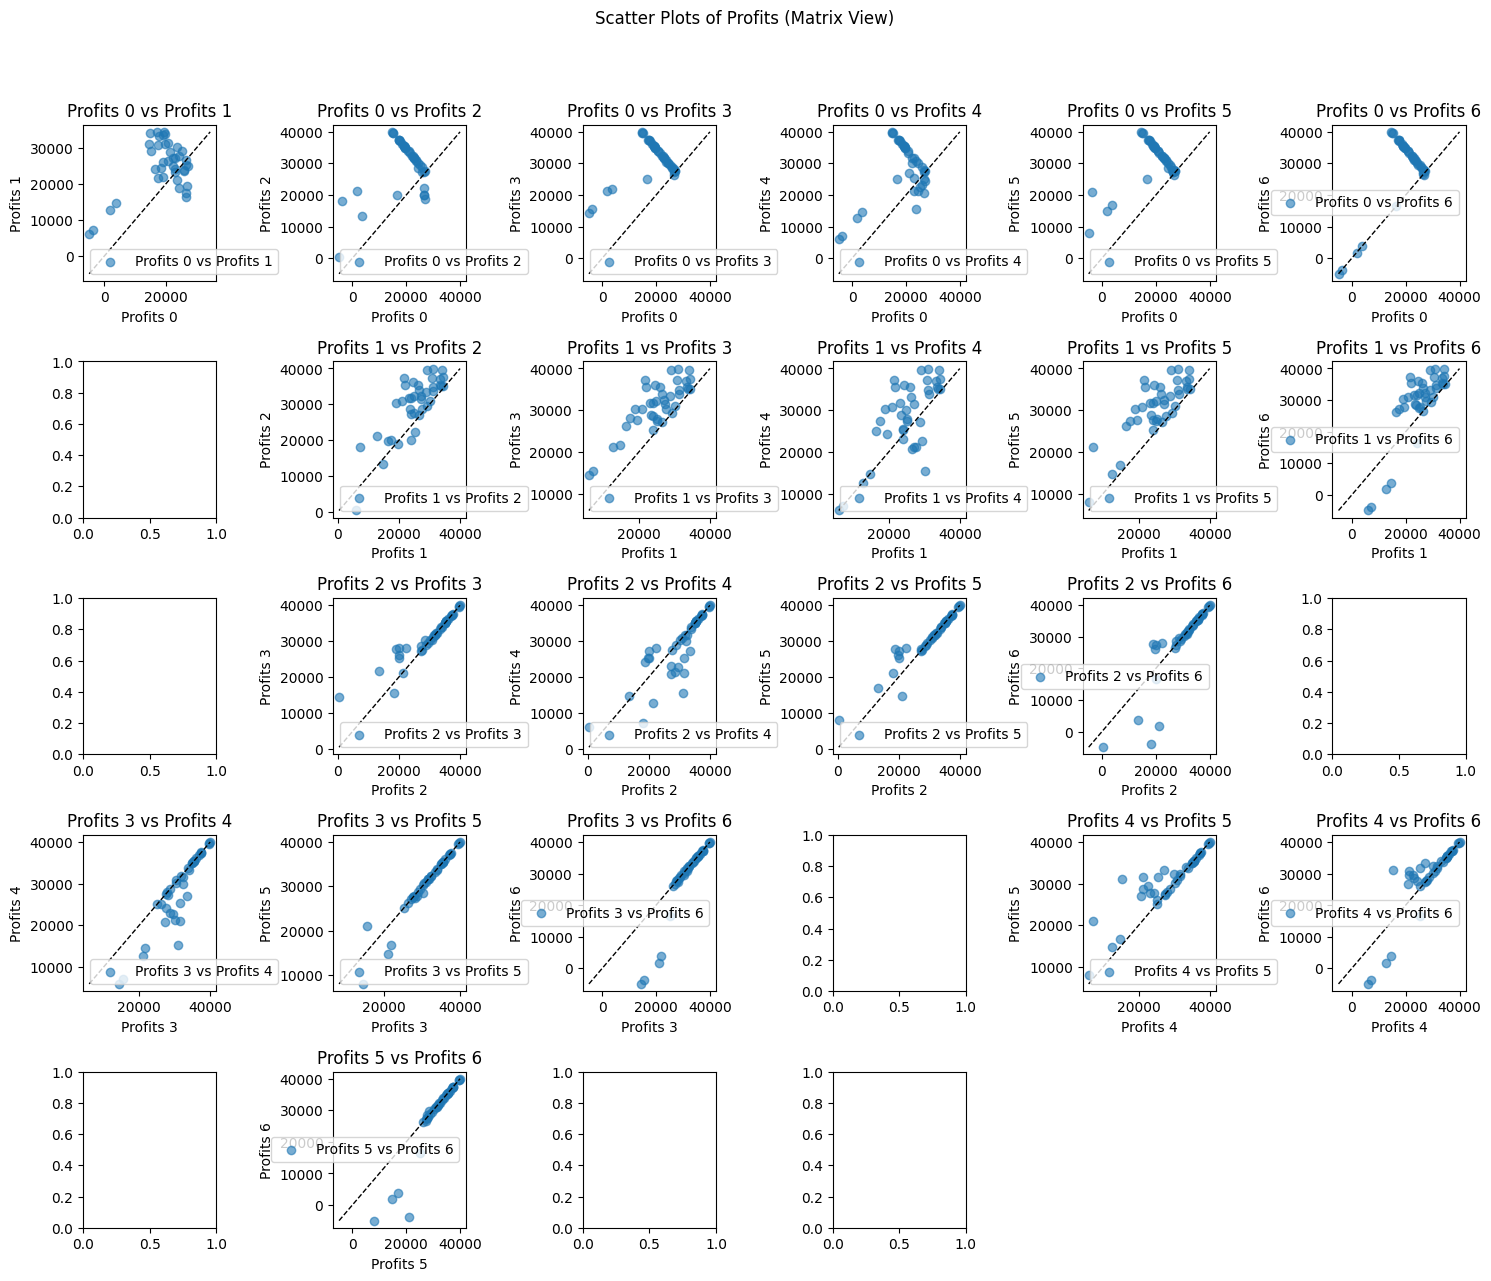

In [ ]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

#### 最大利潤比較


Baseline is: 19309.526261875588
S1's profit: 25044.89166261529
S2's profit: 29791.327699501166
S3's profit: 39967.49433146789
S4's profit: 28515.358498141268
S5's profit: 39967.494331467875
S6's profit: 39967.49433146789
S7's profit: -1
Plot saved as plots/plot_relative_profit_deviation_train_low_50_202411041106.png


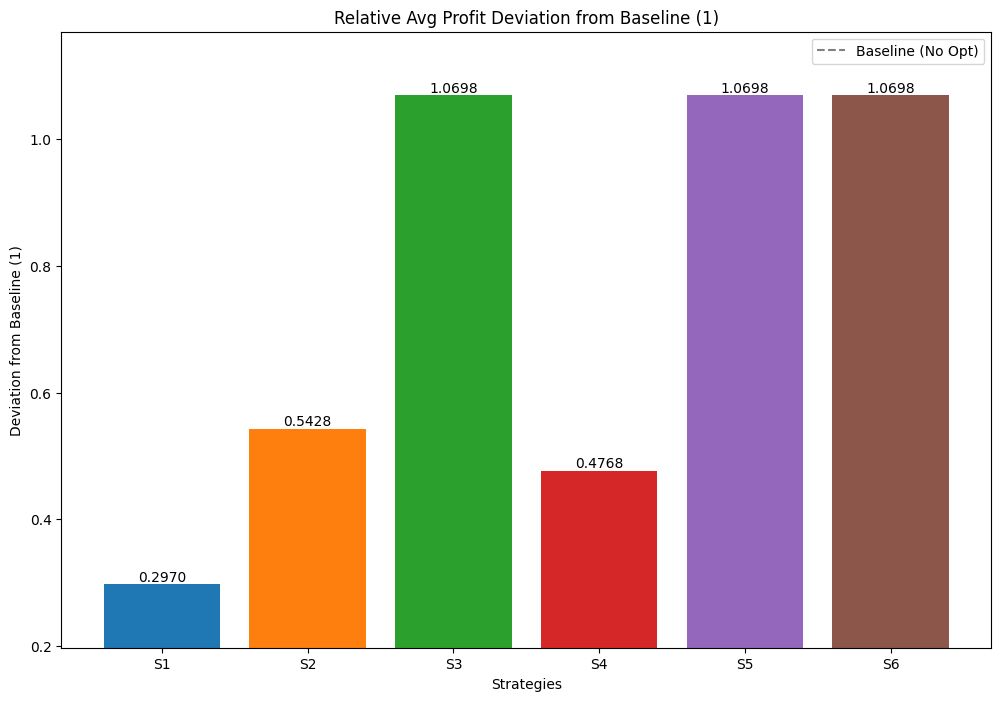

In [ ]:
# 使用範例
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

### Preparation


In [ ]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7

## Testing


### Setting reasonable parameters


In [ ]:
status = "test"

In [ ]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 157.87903781155435
std of sum: 25.32678403729653
20.0 percentile of sum: 136.56347858765005
Q_star: 136.56347858765005


In [ ]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)
Qk_hat_df_test

mu_matrix: [20.75665711 14.34484398 17.38127829 18.52730663 11.42688317  9.24288943
 11.70768751 12.25567027 13.84425952 16.41099414]
covariance_matrix: 
[[ 45.40469575  18.73811153  39.30501323  20.67578616 -35.62612054
  -16.00211943  -2.957299   -18.35898051 -21.7146276   29.43096133]
 [ 18.73811153  34.82844892  16.07839426   5.60415404 -24.91005192
  -10.26109562  -2.73677955  -5.11475935   5.55111984   2.42411329]
 [ 39.30501323  16.07839426  44.02573794   6.16401855 -32.5496682
  -17.43411848 -12.06416746  -4.4870991  -28.25565005  22.54052033]
 [ 20.67578616   5.60415404   6.16401855  62.18465648 -58.57183202
   -0.47890101  30.38628019 -58.25410716   6.45445934  28.62830356]
 [-35.62612054 -24.91005192 -32.5496682  -58.57183202 108.83020946
   18.67035248  -5.27246364  57.40856123   2.5746068  -23.92308784]
 [-16.00211943 -10.26109562 -17.43411848  -0.47890101  18.67035248
   27.42921422   9.35077218   9.26680059  -3.41436356 -19.02113534]
 [ -2.957299    -2.73677955 -12.06416

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0  134.544480  138.833246  150.692003  150.516993  163.043342  163.009429   
1  144.892300  146.156830  140.443909  140.723061  143.950269  143.939053   
2  121.756775  119.224197  122.782999  123.529864  114.808734  114.773145   
3  134.955560  132.855991  138.079416  137.772136  149.235294  149.223319   
4  132.115406  132.594138  136.711014  136.667833  143.962311  144.036053   
5  139.649325  139.665946  137.296201  137.001588  142.996151  142.870620   
6  122.480592  123.472880  118.156372  117.277730  117.819885  117.854413   
7  144.220601  148.355205  149.551451  149.773347  141.329868  141.381805   
8  128.238044  130.309225  126.028671  126.632673  154.941403  154.955485   
9  144.859401  139.253749  141.607389  141.536450  153.044084  153.091531   

    Qk_hat_k8   Qk_hat_k9  
0  163.222615  161.057260  
1  144.799463  140.906454  
2  115.156255  115.483239  
3  152.774762  156.033939  
4  141.193171  143.345156  
5  141.335989  145.152380  
6  118.618895  118.324737  
7  142.647659  147.174011  
8  155.663462  158.146133  
9  152.860285  152.810437

### Run all the strategies


Baseline

In [ ]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/10 with initial inventory Q_star=136.56347858765005
--------------------------------------------------
Day 1
Demand      : 20.581832507042204
Sales       : 20.581832507042204
Loss        : 0
Left        : 115.98164608060785
Inventory   : 115.98164608060785
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 21.070175044749547
Sales       : 21.070175044749547
Loss        : 0
Left        : 94.9114710358583
Inventory   : 94.9114710358583
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 11.051923126831664
Sales       : 11.051923126831664
Loss        : 0
Left        : 83.85954790902663
Inventory   : 83.85954790902663
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 27.32249437056407
Sales       : 27.32249437056407
Loss        : 0
Left        : 56.53705353846256


In [ ]:
test_stimulation_df_baseline

losses      lefts  operation_profits       profits
0  24.960887   0.000000       27312.695718  22320.518346
1   9.229536   0.000000       27312.695718  25466.788492
2   0.000000  19.481994       23416.297011   7830.702184
3  24.862841   0.000000       27312.695718  22340.127452
4  12.635181   0.000000       27312.695718  24785.659522
5  10.372920   0.000000       27312.695718  25238.111663
6   0.000000  17.616074       23789.480827   9696.621266
7  10.919654   0.000000       27312.695718  25128.764889
8  22.443650   0.000000       27312.695718  22823.965788
9  15.023313   0.000000       27312.695718  24308.033044

S1

In [ ]:
results_df_1

R(T)    F          Q0  average_profits  average_losses  average_lefts  \
53     7  0.9  122.907131     25044.891663       11.331867       2.497711   
52     7  0.8  109.250783     24834.716065       12.506703       2.173013   
62     8  0.9  122.907131     24543.163803       10.794282       3.393664   
43     6  0.8  109.250783     22302.378035       17.548190       2.817692   
44     6  0.9  122.907131     22170.063904       16.910150       3.302105   
..   ...  ...         ...              ...             ...            ...   
55     8  0.2   27.312696    -62574.270813       84.627632      75.373782   
65     9  0.3   40.969044    -67732.896457       85.824408      81.223676   
54     8  0.1   13.656348    -78961.888244       98.283980      89.030130   
64     9  0.2   27.312696    -84120.513888       99.480755      94.880024   
63     9  0.1   13.656348   -100508.131318      113.137103     108.536372   

    average_operation_profits  baseline_profit  profit_diff_percent  
53               29309.434079     19309.526262            29.702258  
52               29074.466978     19309.526262            28.613803  
62               29416.951091     19309.526262            27.103915  
43               28066.169609     19309.526262            15.499354  
44               28193.777594     19309.526262            14.814126  
..                        ...              ...                  ...  
55               14650.281075     19309.526262          -424.059068  
65               14410.926047     19309.526262          -450.774512  
54               11919.011503     19309.526262          -508.927113  
64               11679.656475     19309.526262          -535.642557  
63                8948.386904     19309.526262          -620.510602  

[72 rows x 9 columns]

In [ ]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.9, R: 7
Q_star 為 136.56347858765005
期初庫存 Q0: 122.90713072888505
重新估計量 Qk_hat: 163.00942940470065
訂貨量 Q1 為 40.102298675815604

第一階段：期初庫存 Q0: 122.90713072888505，需求量為 104.04122207381788，Sold_0 為 104.04122207381788，Left_0 為 18.865908655067173，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 58.96820733088278，需求量為 57.483143371744355，Sold_1 為 57.483143371744355，Left_1 為 1.4850639591384223，Lost_1 為 0

統計結果：Sold 為 161.52436544556224, Lost 為 0 Left_Penalty_Cost 為 1188.0511673107378，Lost_Penalty_Cost 為 0，Profit 為 31116.821921801708
----------------------------------------
這是第 2 筆模擬資料

F: 0.9, R: 7
Q_star 為 136.56347858765005
期初庫存 Q0: 122.90713072888505
重新估計量 Qk_hat: 143.9390533214764
訂貨量 Q1 為 21.031922592591343

第一階段：期初庫存 Q0: 122.90713072888505，需求量為 101.49634508106266，Sold_0 為 101.49634508106266，Left_0 為 21.410785647822394，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 42.44270824041374，需求量為 44.296669634971025，Sold_1 為 42.44270824041374，Left_1 為 0.0，Lost_1 為 1.8539613945572881

統計結果：Sold 為 143.939053321

R(T)    F          Q0  average_profits  average_losses  average_lefts  \
0     7  0.9  122.907131     26820.147227        3.343832       1.277518   

   average_operation_profits  
0               28510.927647

S2

In [ ]:
results_df_2

R(T)                                                  R  average_profits  \
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     29791.327700   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...     29546.551839   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...     29454.895633   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     29040.835679   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...     27695.008214   

   average_losses  average_lefts  average_operation_profits  \
1        0.000000      88.822980               31575.807562   
2        0.000000      72.029532               31575.807562   
3        0.000000      54.988687               31575.807562   
0        0.000000     108.341262               31575.807562   
4        0.134056      69.968047               31548.996339   

                     alpha_values  \
1   [0.0, 0.0, 2.243662827656465]   
2    [0.0, 0.0, 2.45410500820561]   
3   [0.0, 0.0, 8.560741964485777]   
0  [0.0, 0.0, 1.5024918679850785]   
4           [0.0, 0.0, 1000000.0]   

                                              F_vars  \
1  [0.5585812916546653, 0.722334045334274, 0.9041...   
2  [0.6080824503605237, 0.7586304713071478, 0.878...   
3  [0.5911295823647191, 0.7281027081293117, 0.999...   
0  [0.7387164172420172, 0.7621737219493125, 0.817...   
4  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                             Q0_vars  \
1  [76.2818042623438, 98.64444993313776, 123.4673...   
2  [83.04185468933514, 103.60121612429253, 119.91...   
3  [80.72671206379084, 99.43223859122726, 136.537...   
0  [100.88168362837577, 104.08509475749449, 111.7...   
4  [136.56347858765005, 136.56347858765005, 136.5...   

                                             Q1_vars  
1  [39.01580269466406, 39.0158749317315, 39.01592...  
2  [39.01581591794688, 39.01588061111556, 39.0159...  
3  [39.01546633087594, 39.015642457390115, 39.015...  
0  [39.015907228931994, 39.015912783111816, 39.01...  
4  [2.5386868092880377, 8.35380512774671, 38.2037...

In [ ]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_2

assigned_R: 1


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_18863/1149000371.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left                   alpha_values  \
0     23561.218398   2466.608613   2466.608613  [0.0, 0.0, 2.243662827656465]   

   R(T)  
0     3

In [ ]:
test_stimulation_results_df_2

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1    Left_1  \
0  0.904103     3  41.652008   81.815375     0.0   97.181238  0.000000   
1  0.904103     3  47.766861   75.700521     0.0   98.026154  0.363815   
2  0.904103     3  16.097725  107.369658     0.0  100.983760  6.385897   
3  0.904103     3  31.210559   92.256824     0.0  101.645432  0.000000   
4  0.904103     3  32.512166   90.955217     0.0  100.081972  0.000000   
5  0.904103     3  39.929647   83.537735     0.0   99.736299  0.000000   
6  0.904103     3  22.894297  100.573085     0.0   96.053107  4.525475   
7  0.904103     3  51.927465   71.539917     0.0   95.555668  0.872073   
8  0.904103     3  31.003734   92.463648     0.0   99.305491  0.000000   
9  0.904103     3  36.020549   87.446833     0.0  103.233200  0.000000   

      Lost_1       profits          Q0         Q1  
0  22.691120  23228.425112  123.467382  15.365863  
1   0.000000  28867.550709  123.467382  22.689448  
2   0.000000  18307.579120  123.467382   0.000000  
3  28.570329  20857.132514  123.467382   9.388609  
4  16.604522  23197.923094  123.467382   9.126755  
5   7.270453  26479.098734  123.467382  16.198564  
6   0.000000  20169.100520  123.467382   0.005497  
7   0.000000  28798.968465  123.467382  24.887823  
8  28.697903  20322.264544  123.467382   6.841843  
9  12.333043  25384.141165  123.467382  15.786366

S3

In [ ]:
results_df_3

average_profits  average_losses  average_lefts  average_operation_profits  \
0     31191.108319        0.029182      67.441752                31569.97108   

                    alpha_values  \
0  [0.0, 0.0, 1.613569245141146]   

                                         beta_values  
0  [[-1.6135692451411499], [-1.6135692451411499],...

In [ ]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None:
    alphas = results_df_3.iloc[0]["alpha_values"]
    betas = results_df_3.iloc[0]["beta_values"]

    test_results_df_3, test_stimulation_results_df_3 = (
        cal_test_fully_flexible_simple_beta_with_softmax_3(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_3

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_18863/635627248.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left                   alpha_values  \
0     23743.787991   1345.478286   1345.478286  [0.0, 0.0, 1.613569245141146]   

                                         beta_balues  
0  [[-1.6135692451411499], [-1.6135692451411499],...

In [ ]:
test_stimulation_results_df_3

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1    Left_1  \
0  0.833906     2  20.581833   93.299318     0.0  113.962647  0.000000   
1  0.833906     2  28.559357   85.321794     0.0  116.332943  0.000000   
2  0.833906     2  10.723310  103.157840     0.0  106.358175  4.675290   
3  0.833906     2  20.898750   92.982401     0.0  114.056810  0.000000   
4  0.833906     2  18.709168   95.171982     0.0  113.406238  0.000000   
5  0.833906     2  24.517350   89.363801     0.0  115.131975  0.000000   
6  0.833906     2  11.281327  102.599823     0.0  107.666077  3.533187   
7  0.833906     2  28.041519   85.839632     0.0  116.179082  0.000000   
8  0.833906     2  15.719964   98.161187     0.0  112.518080  0.000000   
9  0.833906     2  28.533993   85.347157     0.0  116.325407  0.000000   

      Lost_1       profits          Q0         Q1  
0  26.979886  21512.918729  113.881151  20.663329  
1   0.900714  28798.317225  113.881151  31.011150  
2   0.000000  19676.064672  113.881151   7.875625  
3  26.470760  21696.960012  113.881151  21.074409  
4  17.083254  23006.430499  113.881151  18.234255  
5   7.287074  26472.450289  113.881151  25.768175  
6   0.000000  20962.930920  113.881151   8.599441  
7   3.262532  28191.613864  113.881151  30.339450  
8  30.769084  19493.791882  113.881151  14.356893  
9   6.727391  27626.401819  113.881151  30.978250

S4

In [ ]:
results_df_4

R(T)  average_losses  \
0  [9, 6, 4, 9, 9, 9, 9, 6, 8, 9, 9, 9, 9, 9, 9, ...        2.076451   

   average_lefts  average_operation_profits  average_profits  \
0      33.972432               31160.517371     28515.358498   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                              F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...   

                                             Q0_vars  \
0  [122.90713072888505, 122.90713072888505, 122.9...   

                                             Q1_vars  
0  [28.16554747557879, 22.010152986511713, 36.026...

In [ ]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    assigned_F = results_df_4.iloc[0]["F_vars"]
    betas = results_df_4.iloc[0]["beta_values"]
    test_results_df_4, test_stimulation_results_df_4 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_4

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_18863/2606609425.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     23617.636434   1345.478286   1345.478286   

                                         beta_balues    F  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....  0.9

In [ ]:
test_stimulation_results_df_4

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1    Left_1     Lost_1  \
0  0.9     2  20.581833  102.325298     0.0  113.962647  0.000000  26.979886   
1  0.9     2  28.559357   94.347774     0.0  116.332943  0.000000   0.900714   
2  0.9     2  10.723310  112.183820     0.0  106.358175  5.825646   0.000000   
3  0.9     2  20.898750  102.008381     0.0  114.056810  0.000000  26.470760   
4  0.9     2  18.709168  104.197962     0.0  113.406238  0.000000  17.083254   
5  0.9     2  24.517350   98.389781     0.0  115.131975  0.000000   7.287074   
6  0.9     2  11.281327  111.625803     0.0  107.666077  3.959727   0.000000   
7  0.9     2  28.041519   94.865612     0.0  116.179082  0.000000   3.262532   
8  0.9     2  15.719964  107.187167     0.0  112.518080  0.000000  30.769084   
9  0.9     2  28.533993   94.373138     0.0  116.325407  0.000000   6.727391   

        profits          Q0         Q1  
0  21512.918729  122.907131  11.637349  
1  28798.317225  122.907131  21.985170  
2  18755.780471  122.907131   0.000000  
3  21696.960012  122.907131  12.048429  
4  23006.430499  122.907131   9.208275  
5  26472.450289  122.907131  16.742194  
6  20621.699553  122.907131   0.000000  
7  28191.613864  122.907131  21.313470  
8  19493.791882  122.907131   5.330913  
9  27626.401819  122.907131  21.952270

S5

In [ ]:
results_df_5

average_profits  average_losses  average_lefts  average_operation_profits  \
0     30818.942116             0.0      47.715727               31575.807562   

                      alpha_values  \
0  [0.11623574544999149, 0.0, 0.0]   

                                         beta_values  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [ ]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_5

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_18863/18362809.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0      22088.49303   1345.478286   1345.478286   

                      alpha_values  \
0  [0.11623574544999149, 0.0, 0.0]   

                                         beta_balues  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

S6

In [ ]:
results_df_6

average_profits  average_losses  average_lefts  average_operation_profits  \
0      29019.14185             0.0      54.034896               31575.807562   

                  alpha_values  \
0  [0.0, 0.0, 9.9367771034199]   

                                         beta_values  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [ ]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_6

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_18863/1094914333.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left                 alpha_values  \
0     22088.637775   1345.478286   1345.478286  [0.0, 0.0, 9.9367771034199]   

                                         beta_balues  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [ ]:
test_stimulation_results_df_6

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1     Left_1  \
0  0.999952     2  20.581833  115.975042     0.0  115.975042   0.000000   
1  0.999952     2  28.559357  107.997517     0.0  116.332943   0.000000   
2  0.999952     2  10.723310  125.833564     0.0  106.358175  19.475389   
3  0.999952     2  20.898750  115.658124     0.0  115.658124   0.000000   
4  0.999952     2  18.709168  117.847706     0.0  117.847706   0.000000   
5  0.999952     2  24.517350  112.039524     0.0  115.131975   0.000000   
6  0.999952     2  11.281327  125.275547     0.0  107.666077  17.609470   
7  0.999952     2  28.041519  108.515356     0.0  116.179082   0.000000   
8  0.999952     2  15.719964  120.836910     0.0  120.836910   0.000000   
9  0.999952     2  28.533993  108.022881     0.0  116.325407   0.000000   

      Lost_1       profits          Q0        Q1  
0  24.967491  22317.876630  136.556874  0.000000  
1   0.900714  28798.317225  136.556874  8.335426  
2   0.000000   7835.985615  136.556874  0.000000  
3  24.869446  22337.485736  136.556874  0.000000  
4  12.641785  24783.017807  136.556874  0.000000  
5   7.287074  26472.450289  136.556874  3.092451  
6   0.000000   9701.904698  136.556874  0.000000  
7   3.262532  28191.613864  136.556874  7.663727  
8  22.450254  22821.324072  136.556874  0.000000  
9   6.727391  27626.401819  136.556874  8.302526

S7

In [ ]:
results_df_7

In [ ]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_7

In [ ]:
test_stimulation_results_df_7

### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_low_50_202411041106.png


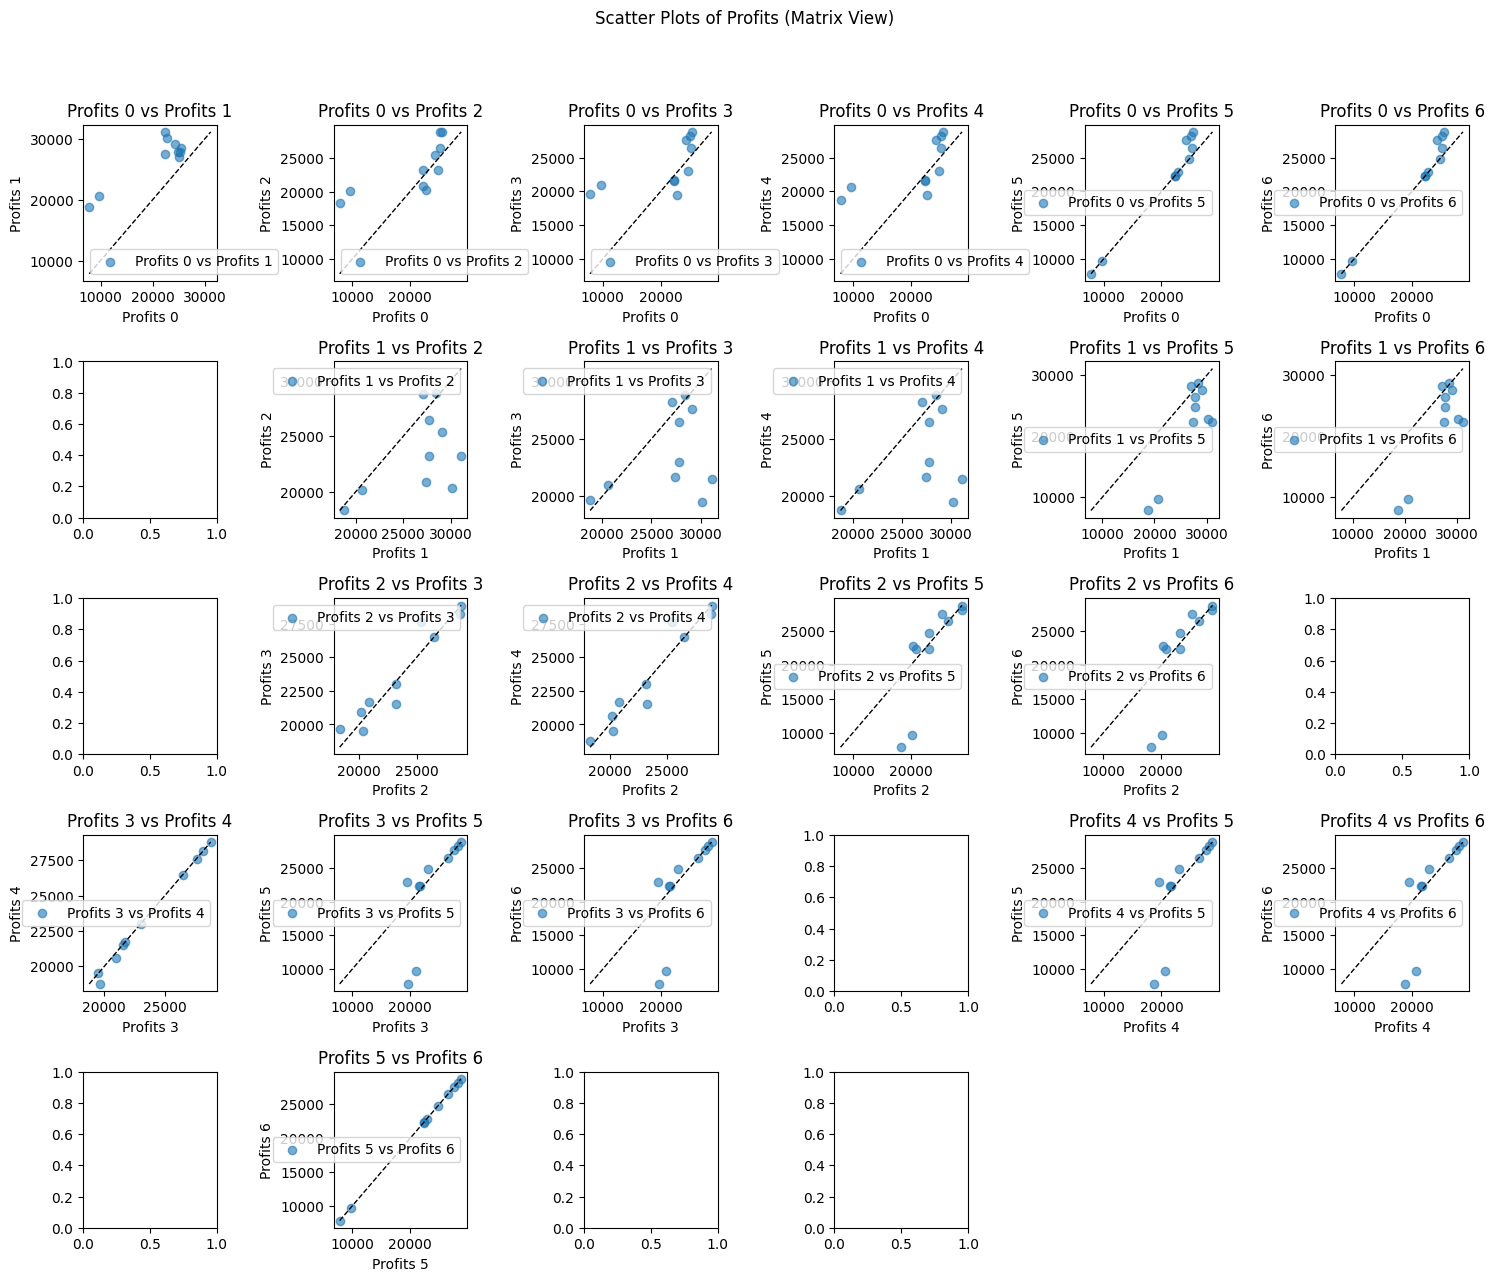

In [ ]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 20993.929264625385
S1's profit: 26820.147226888617
S2's profit: 23561.218397747944
S3's profit: 23743.787991211342
S4's profit: 23617.636434328095
S5's profit: 22088.49302971151
S6's profit: 22088.63777549754
S7's profit: -1
Plot saved as plots/plot_relative_profit_deviation_test_low_50_202411041106.png


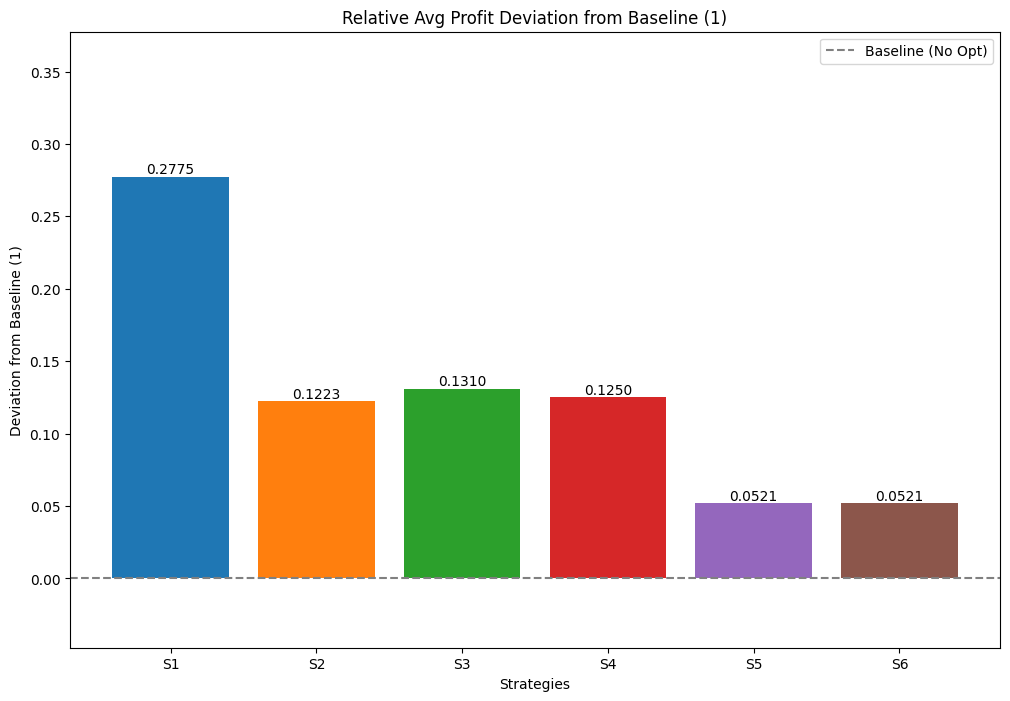

In [ ]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_low_50_202411041106.png


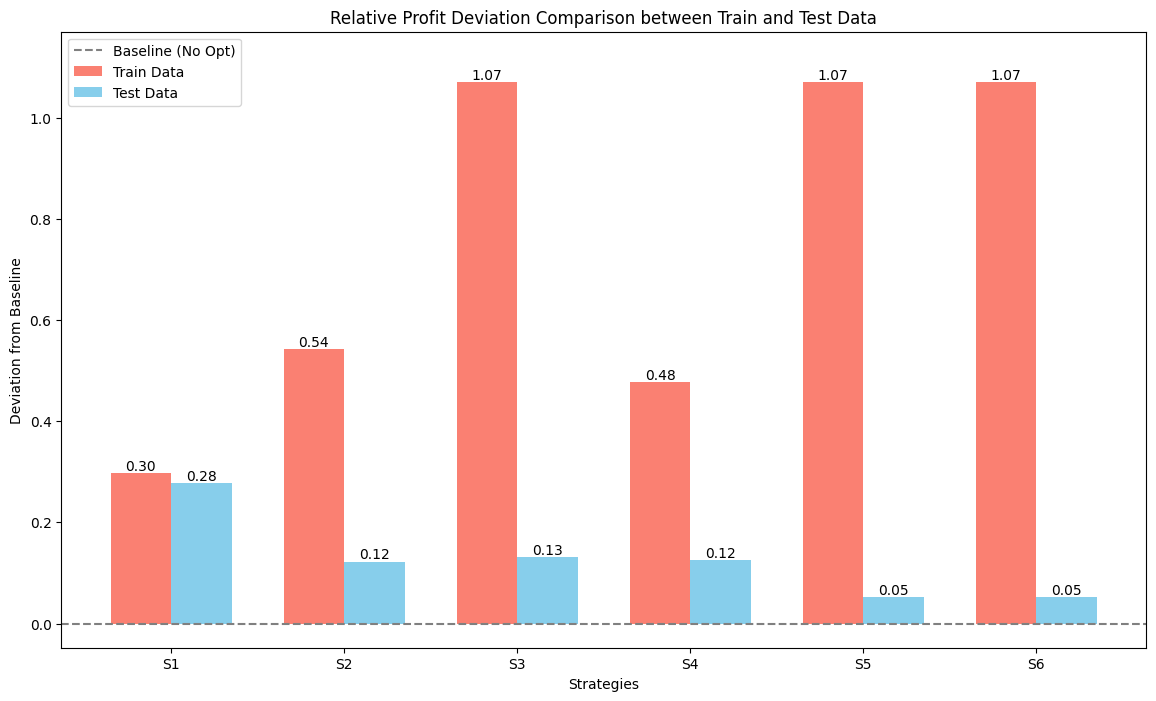

In [ ]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [ ]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]

# 總和分析


In [ ]:
# # Plotting
# plt.figure(figsize=(16, 30))

# # Traverse through different F values to plot merged subplots
# for idx, F in enumerate(assigned_Fs):
#     plt.subplot(len(assigned_Fs), 1, idx + 1)

#     # Select high baseline data corresponding to F
#     subset_high = (
#         high_results_df_1[high_results_df_1["F"] == F].sort_values(by="R").dropna()
#     )
#     plt.plot(
#         subset_high["R"],
#         subset_high["profit_diff_percent"],
#         marker="s",
#         linestyle="-",
#         color="blue",
#         label="High Baseline",
#     )

#     # Mark each data point with rounded value (up to two decimal places)
#     for x, y in zip(subset_high["R"], subset_high["profit_diff_percent"]):
#         plt.text(x, y, f"{y:.2f}", fontsize=12, color="blue", ha="left", va="bottom")

#     # Select low baseline data corresponding to F
#     subset_low = (
#         low_results_df_1[low_results_df_1["F"] == F].sort_values(by="R").dropna()
#     )
#     plt.plot(
#         subset_low["R"],
#         subset_low["profit_diff_percent"],
#         marker="o",
#         linestyle="-",
#         color="red",
#         label="Low Baseline",
#     )

#     # Mark each data point with rounded value (up to two decimal places)
#     for x, y in zip(subset_low["R"], subset_low["profit_diff_percent"]):
#         plt.text(x, y, f"{y:.2f}", fontsize=12, color="red", ha="right", va="top")

#     plt.xlabel("R")
#     plt.ylabel("Profit Difference (%)")
#     plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
#     plt.grid(True)
#     plt.legend()

# plt.tight_layout()
# plt.show()

# Drafts


In [ ]:
# def check_values(Q1, Q_hat_adjusted, Q0,
#                  Sold_0, total_demand_up_to_k_minus_1,
#                  Q0_var, Sold_1, total_demand_from_k_to_T,
#                  Q1_plus_left, Left_0, Lost_0, Left_1, Lost_1):

#     i=0
#     print("---------------------------------------")
#     print(f"Start to check the values: ")

#     # 檢查條件 1：Q1_vars[i].X 一定是等於 Q_hats[i].X - Q0_vars[i].X（值為 Q_hat_adjusted） 或是 0
#     if not (Q1 == Q_hat_adjusted or Q1 == 0):
#         print(f"Error: Q1 ({Q1}) should be equal to Q_hat_adjusted ({Q_hat_adjusted}) or 0")
#         i+=1

#     # 檢查條件 2：Sold_0s[i].X 一定等於 total_demand_up_to_k_minus_1_vars[i].X 或是 Q0_vars[i].X
#     if not (Sold_0 == total_demand_up_to_k_minus_1 or Sold_0 == Q0):
#         print(f"Error: Sold_0 ({Sold_0}) should be equal to total_demand_up_to_k_minus_1 ({total_demand_up_to_k_minus_1}) or Q0 ({Q0})")
#         i+=1

#     # 檢查條件 3：Sold_1s[i].X 一定等於 total_demand_from_k_to_T_vars[i].X 或是 Q1_plus_lefts[i].X
#     if not (Sold_1 == total_demand_from_k_to_T or Sold_1 == Q1_plus_left):
#         print(f"Error: Sold_1 ({Sold_1}) should be equal to total_demand_from_k_to_T ({total_demand_from_k_to_T}) or Q1_plus_left ({Q1_plus_left})")
#         i+=1

#     # 檢查條件 4：Left_0s[i].X 一定等於 Q0_vars[i].X - Sold_0s[i].X 或是 0
#     if not (Left_0 == Q0 - Sold_0 or Left_0 == 0):
#         print(f"Error: Left_0 ({Left_0}) should be equal to Q0 - Sold_0 ({Q0 - Sold_0}) or 0")
#         i+=1

#     # 檢查條件 5：Left_1s[i].X 一定等於 Q1_plus_lefts[i].X - Sold_1s[i].X 或是 0
#     if not (Left_1 == Q1_plus_left - Sold_1 or Left_1 == 0):
#         print(f"Error: Left_1 ({Left_1}) should be equal to Q1_plus_left - Sold_1 ({Q1_plus_left - Sold_1}) or 0")
#         i+=1

#     # 檢查條件 6：Lost_0s[i].X 一定等於 total_demand_up_to_k_minus_1_vars[i].X - Q0_vars[i].X 或是 0
#     if not (Lost_0 == total_demand_up_to_k_minus_1 - Q0 or Lost_0 == 0):
#         print(f"Error: Lost_0 ({Lost_0}) should be equal to total_demand_up_to_k_minus_1 - Q0 ({total_demand_up_to_k_minus_1 - Q0}) or 0")
#         i+=1

#     # 檢查條件 7：Lost_1s[i].X 一定等於 total_demand_from_k_to_T_vars[i].X - Q1_plus_lefts[i].X 或是 0
#     if not (Lost_1 == total_demand_from_k_to_T - Q1_plus_left or Lost_1 == 0):
#         print(f"Error: Lost_1 ({Lost_1}) should be equal to total_demand_from_k_to_T - Q1_plus_left ({total_demand_from_k_to_T - Q1_plus_left}) or 0")
#         i+=1

#     if i == 0:
#         print(f"All Pass!")
#     else:
#         print(f"There are {i} wrongs!")

#     print("---------------------------------------")

In [ ]:
# # ### 0~k-1 的需求量
# total_demand_up_to_k_minus_1_var = model.addVar(name=f"Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_var == gp.quicksum(R_vars[i, k-2] * demand_row[:k-1].sum() for k in range(2, T)), name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_vars[i] == total_demand_up_to_k_minus_1_var, name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}")

# # ### k~T 的需求量
# total_demand_from_k_to_T_var = model.addVar(name=f"Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_var == gp.quicksum(R_vars[i, k-2] * demand_row[k-1:].sum() for k in range(2, T)), name=f"Constr_Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var, name=f"Calculate_Total_Demand_from_k_to_T_{i}")

# # 計算 Sold_0
# model.addConstr(Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i], name=f"Constr_Sold_0_1_{i}")
# model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

# # 計算 Left_0
# aux_left_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_0_{i}")
# model.addConstr(aux_left_0 == Q0_vars[i] - Sold_0s[i], name=f"constr_aux_left_0_{i}")
# model.addConstr(Left_0s[i] >= aux_left_0, name=f"Constr_Left_0_1_{i}")
# model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")
# model.addConstr(Left_0s[i] <= aux_left_0, name=f"Constr_Left_0_3_{i}")

# # 計算 Lost_0
# aux_lost_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_0_{i}")
# model.addConstr(aux_lost_0 == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"constr_aux_lost_0_{i}")
# model.addConstr(Lost_0s[i] >= aux_lost_0, name=f"Constr_Lost_0_1_{i}")
# model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")
# model.addConstr(Lost_0s[i] <= aux_lost_0, name=f"Constr_Lost_0_3_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addConstr(Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Constr_Sold_1_1_{i}")
# model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

# # 計算 Left_1
# aux_left_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_1_{i}")
# model.addConstr(aux_left_1 == Q1_plus_lefts[i] - Sold_1s[i], name=f"constr_aux_left_1_{i}")
# model.addConstr(Left_1s[i] >= aux_left_1, name=f"Constr_Left_1_1_{i}")
# model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")
# model.addConstr(Left_1s[i] <= aux_left_1, name=f"Constr_Left_1_3_{i}")

# # 計算 Lost_1
# aux_lost_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_1_{i}")
# model.addConstr(aux_lost_1 == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"constr_aux_lost_1_{i}")
# model.addConstr(Lost_1s[i] >= aux_lost_1, name=f"Constr_Lost_1_1_{i}")
# model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")
# model.addConstr(Lost_1s[i] <= aux_lost_1, name=f"Constr_Lost_1_3_{i}")


# # 統計本次 Profit for this stimulation
# model.addConstr(profits_vars[i] == (
#             (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
#             - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
#             - (cost - salvage_value) * Left_1s[i]  # left, only considering Left_1
# ), name=f"Profit_Constraint_{i}")

In [ ]:
# # ### 0~k-1 的需求量
# total_demand_up_to_k_minus_1_var = model.addVar(name=f"Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_var == gp.quicksum(R_vars[i, k-2] * demand_row[:k-1].sum() for k in range(2, T)), name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_vars[i] == total_demand_up_to_k_minus_1_var, name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}")

# # ### k~T 的需求量
# total_demand_from_k_to_T_var = model.addVar(name=f"Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_var == gp.quicksum(R_vars[i, k-2] * demand_row[k-1:].sum() for k in range(2, T)), name=f"Constr_Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var, name=f"Calculate_Total_Demand_from_k_to_T_{i}")

# # 計算 Sold_0
# model.addConstr(Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i], name=f"Constr_Sold_0_1_{i}")
# model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

# # 計算 Left_0
# model.addConstr(Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}")
# model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

# # 計算 Lost_0
# model.addConstr(Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"Constr_Lost_0_1_{i}")
# model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addConstr(Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Constr_Sold_1_1_{i}")
# model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

# # 計算 Left_1
# model.addConstr(Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}")
# model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

# # 計算 Lost_1
# model.addConstr(Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"Constr_Lost_1_1_{i}")
# model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

# # 統計本次 Profit for this stimulation
# model.addConstr(profits_vars[i] == (
#             (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
#             - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
#             - (cost - salvage_value) * Left_1s[i]  # left, only considering Left_1
# ), name=f"Profit_Constraint_{i}")

In [ ]:
# # 計算 Sold_0
# model.addGenConstrMin(Sold_0s[i], [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]], name=f"Sold_0_{i}")

# # 計算 Left_0
# aux_left_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_0_{i}")
# model.addConstr(aux_left_0 == Q0_vars[i] - Sold_0s[i], name=f"constr_aux_left_0_{i}")
# model.addGenConstrMax(Left_0s[i], [aux_left_0], 0.0, f"Left_0_Max_{i}")

# # 計算 Lost_0
# aux_lost_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_0_{i}")
# model.addConstr(aux_lost_0 == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"constr_aux_lost_0_{i}")
# model.addGenConstrMax(Lost_0s[i], [aux_lost_0], 0.0, f"Lost_0_Max_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addGenConstrMin(Sold_1s[i], [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],  name=f"Sold_1_{i}")

# # 計算 Left_1
# aux_left_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_1_{i}")
# model.addConstr(aux_left_1 == Q1_plus_lefts[i] - total_demand_from_k_to_T_vars[i], name=f"constr_aux_left_1_{i}")
# model.addGenConstrMax(Left_1s[i], [aux_left_1], 0.0, f"Left_1_Max_{i}")

# # 計算 Lost_1
# aux_lost_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_1_{i}")
# model.addConstr(aux_lost_1 == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"constr_aux_lost_1_{i}")
# model.addGenConstrMax(Lost_1s[i], [aux_lost_1], 0.0, f"Lost_1_Max_{i}")